<a href="https://colab.research.google.com/github/Amine-OMRI/Airbnb-Pricing-Prediction-/blob/main/Projet_Data_Science_Analysis_part.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.impute import SimpleImputer

In [ ]:
%matplotlib inline
sns.set()

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['text.color'] = 'k'
plt.rcParams['figure.figsize'] = 15, 5

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


#Data Exploration and Pre-processing
---


Importing Listings Data
Detailed Listings data for Paris


In [ ]:
%%time
# Load listings dataset which contain information about the owner as well as the rented property (location, price etc...)
#To preserve multiple languages ‘utf-8’ encoding will be used across the files.
df_listings = pd.read_csv("http://data.insideairbnb.com/france/ile-de-france/paris/2020-12-14/data/listings.csv.gz", encoding='utf-8')

CPU times: user 3.45 s, sys: 226 ms, total: 3.67 s
Wall time: 4.35 s


In [ ]:
df_listings.head()

id  ... reviews_per_month
0  2577  ...              0.04
1  3109  ...              0.19
2  4890  ...              0.21
3  5396  ...              1.65
4  7397  ...              2.28

[5 rows x 74 columns]

##Colonnes à ajouter a listings dataset

- **id:** identifiant de la listing qui peut être utilisé pour créer une jointure avec d'autres datasets



- **last_review**: ce champ servira à filtrer les listes qui ne sont plus actives

- **host_location**: nous pouvons l'utiliser pour déterminer si l'hôte est local ou non


- **host_since**: peut être utilisé pour calculer l'expérience des hôtes en fonction de la durée depuis leur première inscription



- **amenities**: en raison du nombre de caractéristiques uniques (plus de 100), nous nous concentrerons uniquement sur le nombre total de ces équipements.


- **calculated_host_listings_count**: valeur continue qui correspond aux nombres effectifs de listings pour les hôtes - mesure permettant de déterminer l'expérience des hôtes ou de distinguer les entreprises des individus

In [ ]:
df_listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65917 entries, 0 to 65916
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            65917 non-null  int64  
 1   listing_url                                   65917 non-null  object 
 2   scrape_id                                     65917 non-null  int64  
 3   last_scraped                                  65917 non-null  object 
 4   name                                          65853 non-null  object 
 5   description                                   64474 non-null  object 
 6   neighborhood_overview                         39651 non-null  object 
 7   picture_url                                   65916 non-null  object 
 8   host_id                                       65917 non-null  int64  
 9   host_url                                      65917 non-null 

- there are 65917 listings in this dataset
- values in the **host_response_rate** and **host_acceptance_rate** columns contain percentage symbole (%)
- values in the price column contain the dollar symbol ($)
- there are missing values in columns **name, description, neighborhood_overview, picture_url, host_name, host_since, host_location, host_about, host_response_time, host_response_rate, host_acceptance_rate, host_is_superhost, host_thumbnail_url, host_picture_url, host_neighbourhood, host_listings_count, host_total_listings_count, host_has_profile_pic, host_identity_verified, neighbourhood, bathrooms_text, bedrooms, beds, minimum_minimum_nights, maximum_minimum_nights, minimum_maximum_nights, maximum_maximum_nights, minimum_nights_avg_ntm, maximum_nights_avg_ntm, first_review, last_review, review_scores_rating, review_scores_accuracy, review_scores_cleanliness, review_scores_checkin, review_scores_communication, review_scores_location, review_scores_value, license adn reviews_per_month**

In [ ]:
df_listings.describe()

id  ...  reviews_per_month
count  6.591700e+04  ...       50229.000000
mean   2.414158e+07  ...           0.689335
std    1.417034e+07  ...           0.983954
min    2.577000e+03  ...           0.010000
25%    1.183532e+07  ...           0.130000
50%    2.400377e+07  ...           0.360000
75%    3.708021e+07  ...           0.870000
max    4.702923e+07  ...          39.620000

[8 rows x 40 columns]

##Nettoyage du dataset listings

- La colonne Price, qui est le prix de l'annonce, contient le signe du dollar ($). Nous ne pouvons toujours pas l'utiliser pour l'analyse car il ne s'agit pas d'une valeur numérique, nous retirons donc le symbole du dollar et convertissons les valeurs en valeurs numériques :


In [ ]:
df_listings['price']

0          $125.00
1           $60.00
2           $69.00
3           $62.00
4           $53.00
           ...    
65912      $176.00
65913    $1,179.00
65914    $1,179.00
65915       $24.00
65916      $110.00
Name: price, Length: 65917, dtype: object

In [ ]:
df_listings['price'] = df_listings['price'].str.replace("[$, ]", "").astype("float")

In [ ]:
df_listings['price'].describe()

count    65917.000000
mean       114.280205
std        220.155923
min          0.000000
25%         59.000000
50%         80.000000
75%        120.000000
max      11600.000000
Name: price, dtype: float64

In [ ]:
len(df_listings[df_listings.price == 0])

59

- Comme nous pouvons le voir, il y a 59 lignes avec un **`prix = 0`**, ce qui peut être une erreur lors de la saisie des données, mais pour corriger cela, ces lignes doivent être remplies des NAs pour qu'elles soient imputées plus tard

In [ ]:
df_listings['price'] = df_listings['price'].replace(0,np.nan)

In [ ]:
df_listings.price.isna().sum()

59

In [ ]:
df_listings.price.describe()

count    65858.000000
mean       114.382585
std        220.227931
min          8.000000
25%         60.000000
50%         80.000000
75%        120.000000
max      11600.000000
Name: price, dtype: float64

- meme chose pour la colonne **beds**

In [ ]:
df_listings['beds'] = df_listings['beds'].replace(0,np.nan)

In [ ]:
df_listings.beds.describe()

count    65317.000000
mean         1.676485
std          1.299781
min          0.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         90.000000
Name: beds, dtype: float64

In [ ]:
df_listings.beds.isna().sum()

2299

- The columns **neighbourhood_group_cleansed**, **bathrooms**, **calendar_updated** are empty (NANs) for all rows in the dataset.

In [ ]:
df_listings['host_response_rate'] = df_listings['host_response_rate'].str.replace("[%, ]", "").astype("float")
df_listings['host_acceptance_rate'] = df_listings['host_acceptance_rate'].str.replace("[%, ]", "").astype("float")

- Renommer la colonne "id" en "listing_id" pour la faire correspondre à la colonne correspondante de l'ensemble de données du calendar.csv


In [ ]:
df_listings.rename(columns={'id':'listing_id'}, inplace=True)

In [ ]:
# Vervier si les listings sont differents (unique)
len(df_listings.listing_id.value_counts()) == df_listings.shape[0]

True

In [ ]:
print("[INFO]: Listings row, cols: ", df_listings.shape)

[INFO]: Listings row, cols:  (65917, 74)


In [ ]:
# vérifier comment les types de données sont distribués.
df_listings.dtypes.value_counts()

object     31
float64    26
int64      17
dtype: int64

In [ ]:
# Définir les propriétés d'affichage afin que nous puissions inspecter les données
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 100)

###Colonnes: Object

In [ ]:
# En utilisant select_dtypes, nous pouvons filtrer le type de colonnes souhaité.
# Selectionner toute les colonnes de type Object
df_listings.select_dtypes(include=['object']).columns

Index(['listing_url', 'last_scraped', 'name', 'description',
       'neighborhood_overview', 'picture_url', 'host_url', 'host_name',
       'host_since', 'host_location', 'host_about', 'host_response_time',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_verifications', 'host_has_profile_pic',
       'host_identity_verified', 'neighbourhood', 'neighbourhood_cleansed',
       'property_type', 'room_type', 'bathrooms_text', 'amenities',
       'has_availability', 'calendar_last_scraped', 'first_review',
       'last_review', 'license', 'instant_bookable'],
      dtype='object')

In [ ]:
df_listings.select_dtypes(include=['object']).head(3)

listing_url last_scraped  \
0  https://www.airbnb.com/rooms/2577   2020-12-16   
1  https://www.airbnb.com/rooms/3109   2020-12-17   
2  https://www.airbnb.com/rooms/4890   2020-12-16   

                                  name  \
0     Loft for 4 by Canal Saint Martin   
1                         zen and calm   
2  Quiet Historic & Cute  +Free Cruise   

                                         description  \
0  100 m2 loft (1100 sq feet) with high ceiling, ...   
1  <b>The space</b><br />I bedroom appartment in ...   
2  Stylish & Classic One bedroom apartment for up...   

                               neighborhood_overview  \
0                                                NaN   
1  Good restaurants<br />very close the Montparna...   
2  Called "Paris Next Great Neighborhood" from Tr...   

                                         picture_url  \
0  https://a0.muscache.com/pictures/09da057c-0120...   
1  https://a0.muscache.com/pictures/baeae9e2-cd53...   
2  https://a0.muscache.com/pictures/b144894f-bc55...   

                                 host_url            host_name  host_since  \
0  https://www.airbnb.com/users/show/2827               Karine  2008-09-09   
1  https://www.airbnb.com/users/show/3631                 Anne  2008-10-14   
2  https://www.airbnb.com/users/show/6792  Ryan Of Cobblestone  2009-01-16   

                           host_location  \
0  Casablanca, Grand Casablanca, Morocco   
1           Paris, Île-de-France, France   
2           Paris, Île-de-France, France   

                                          host_about host_response_time  \
0  Arrivée à Casablanca il y a 4 ans, je suis amo...                NaN   
1                                                NaN                NaN   
2  I am the owner of Cobblestone Paris Rentals\r\...     within an hour   

  host_is_superhost                                 host_thumbnail_url  \
0                 f  https://a0.muscache.com/im/pictures/user/17fe6...   
1                 f  https://a0.muscache.com/im/users/3631/profile_...   
2                 f  https://a0.muscache.com/im/users/6792/profile_...   

                                    host_picture_url host_neighbourhood  \
0  https://a0.muscache.com/im/pictures/user/17fe6...         République   
1  https://a0.muscache.com/im/users/3631/profile_...             Alésia   
2  https://a0.muscache.com/im/users/6792/profile_...          Le Marais   

                                  host_verifications host_has_profile_pic  \
0  ['email', 'phone', 'reviews', 'jumio', 'govern...                    t   
1          ['email', 'phone', 'facebook', 'reviews']                    t   
2  ['email', 'phone', 'reviews', 'offline_governm...                    t   

  host_identity_verified                 neighbourhood neighbourhood_cleansed  \
0                      t                           NaN               Entrepôt   
1                      f  Paris, Île-de-France, France           Observatoire   
2                      t  Paris, Ile-de-France, France                 Temple   

      property_type        room_type bathrooms_text  \
0       Entire loft  Entire home/apt        2 baths   
1  Entire apartment  Entire home/apt         1 bath   
2  Entire apartment  Entire home/apt         1 bath   

                                           amenities has_availability  \
0  ["Dryer", "Host greets you", "Hot water", "Han...                t   
1  ["Children\u2019s books and toys", "Paid parki...                t   
2  ["Dryer", "Host greets you", "Hangers", "Iron"...                t   

  calendar_last_scraped first_review last_review license instant_bookable  
0            2020-12-16   2019-01-02  2019-01-02     NaN                f  
1            2020-12-17   2016-12-27  2019-10-24     NaN                f  
2            2020-12-16   2011-11-22  2020-09-07     NaN                f

- En examinant certaines valeurs de types object, il s'avère que certaines colonnes ne sont pas très utiles pour notre analyse. nous pouvons supprimer ces colonnes.

In [ ]:
%%time
col_to_delete = ['listing_url',            # Ne détient aucune information
                 'last_scraped',           # Ne détient aucune information
                 'picture_url',            # Ne détient aucune information
                 'host_url',               # Ne détient aucune information
                 'host_name',              # Contient des valeures manquantes

                 'host_thumbnail_url',     # Ne détient aucune information
                 'host_picture_url',       # Ne détient aucune information
                 'host_neighbourhood',     # Ne détient aucune information
                 'neighbourhood',          # Ne détient aucune information
                 'calendar_last_scraped',  # Ne détient aucune information
                 'first_review',           # Contient des valeures manquantes (date non imputable)
                 ]  

#                 'host_since',             # Contient des valeures manquantes (date non imputable)
#                 'last_review'             # Contient des valeures manquantes (date non imputable)

CPU times: user 7 µs, sys: 1e+03 ns, total: 8 µs
Wall time: 16.5 µs


###Colonnes: float64

In [ ]:
df_listings.select_dtypes(include=['float64']).columns

Index(['host_response_rate', 'host_acceptance_rate', 'host_listings_count',
       'host_total_listings_count', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'bathrooms', 'bedrooms', 'beds', 'price',
       'minimum_minimum_nights', 'maximum_minimum_nights',
       'minimum_maximum_nights', 'maximum_maximum_nights',
       'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'calendar_updated',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'reviews_per_month'],
      dtype='object')

In [ ]:
df_listings.select_dtypes(include=['float64']).head()

host_response_rate  host_acceptance_rate  host_listings_count  \
0                 NaN                  67.0                  2.0   
1                 NaN                   0.0                  1.0   
2               100.0                 100.0                  9.0   
3               100.0                 100.0                  1.0   
4               100.0                  87.0                  3.0   

   host_total_listings_count  neighbourhood_group_cleansed  latitude  \
0                        2.0                           NaN  48.86993   
1                        1.0                           NaN  48.83349   
2                        9.0                           NaN  48.86409   
3                        1.0                           NaN  48.85207   
4                        3.0                           NaN  48.85758   

   longitude  bathrooms  bedrooms  beds  price  minimum_minimum_nights  \
0    2.36251        NaN       2.0   2.0  125.0                     3.0   
1    2.31852        NaN       NaN   1.0   60.0                     2.0   
2    2.35651        NaN       1.0   2.0   69.0                     5.0   
3    2.35871        NaN       NaN   1.0   62.0                     1.0   
4    2.35275        NaN       2.0   2.0   53.0                     3.0   

   maximum_minimum_nights  minimum_maximum_nights  maximum_maximum_nights  \
0                     3.0                  1125.0                  1125.0   
1                     2.0                    30.0                    30.0   
2                     5.0                  1125.0                  1125.0   
3                     1.0                  1125.0                  1125.0   
4                    15.0                   130.0                   130.0   

   minimum_nights_avg_ntm  maximum_nights_avg_ntm  calendar_updated  \
0                     3.0                  1125.0               NaN   
1                     2.0                    30.0               NaN   
2                     5.0                  1125.0               NaN   
3                     1.0                  1125.0               NaN   
4                    14.9                   130.0               NaN   

   review_scores_rating  review_scores_accuracy  review_scores_cleanliness  \
0                 100.0                    10.0                       10.0   
1                 100.0                    10.0                       10.0   
2                  95.0                    10.0                        9.0   
3                  90.0                     9.0                        9.0   
4                  94.0                    10.0                        9.0   

   review_scores_checkin  review_scores_communication  review_scores_location  \
0                   10.0                         10.0                    10.0   
1                   10.0                         10.0                    10.0   
2                   10.0                         10.0                    10.0   
3                    9.0                         10.0                    10.0   
4                   10.0                         10.0                    10.0   

   review_scores_value  reviews_per_month  
0                 10.0               0.04  
1                 10.0               0.19  
2                 10.0               0.21  
3                  8.0               1.65  
4                 10.0               2.28

In [ ]:
# neighbourhood_group_cleansed --> Colonne vide
# bathrooms --> Colonne vide
# calendar_updated --> Colonne vide
# minimum_nights_avg_ntm --> Ne détient aucune information
# maximum_nights_avg_ntm --> Ne détient aucune information

col_to_delete.extend(['neighbourhood_group_cleansed',
                      'bathrooms', 
                      'calendar_updated',
                      'minimum_nights_avg_ntm', 
                      'maximum_nights_avg_ntm'])
col_to_delete

['listing_url',
 'last_scraped',
 'picture_url',
 'host_url',
 'host_name',
 'host_thumbnail_url',
 'host_picture_url',
 'host_neighbourhood',
 'neighbourhood',
 'calendar_last_scraped',
 'first_review',
 'neighbourhood_group_cleansed',
 'bathrooms',
 'calendar_updated',
 'minimum_nights_avg_ntm',
 'maximum_nights_avg_ntm']

###Colonnes: int64

In [ ]:
df_listings.select_dtypes(include=['int64']).columns

Index(['listing_id', 'scrape_id', 'host_id', 'accommodates', 'minimum_nights',
       'maximum_nights', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'number_of_reviews',
       'number_of_reviews_ltm', 'number_of_reviews_l30d',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms'],
      dtype='object')

In [ ]:
df_listings.select_dtypes(include=['int64']).head()

listing_id       scrape_id  host_id  accommodates  minimum_nights  \
0        2577  20201214191425     2827             4               3   
1        3109  20201214191425     3631             2               2   
2        4890  20201214191425     6792             4               5   
3        5396  20201214191425     7903             2               1   
4        7397  20201214191425     2626             4              15   

   maximum_nights  availability_30  availability_60  availability_90  \
0            1125               30               60               90   
1              30                2                2                2   
2             120                8               37               67   
3            1125               30               60               90   
4             130               13               43               73   

   availability_365  number_of_reviews  number_of_reviews_ltm  \
0               364                  1                      0   
1                 2                  9                      0   
2                67                 23                      1   
3                90                231                     24   
4               348                269                      7   

   number_of_reviews_l30d  calculated_host_listings_count  \
0                       0                               1   
1                       0                               1   
2                       0                              14   
3                       0                               1   
4                       0                               3   

   calculated_host_listings_count_entire_homes  \
0                                            1   
1                                            1   
2                                           14   
3                                            1   
4                                            3   

   calculated_host_listings_count_private_rooms  \
0                                             0   
1                                             0   
2                                             0   
3                                             0   
4                                             0   

   calculated_host_listings_count_shared_rooms  
0                                            0  
1                                            0  
2                                            0  
3                                            0  
4                                            0

In [ ]:
# scrape_id --> identique pour toutes les lignes (20201214191425)
# host_id --> id qui n'est utilisé nulle part ailleurs
# minimum_minimum_nights --> Ne détient aucune information
# maximum_minimum_nights --> Ne détient aucune information
# minimum_maximum_nights --> Ne détient aucune information
# maximum_maximum_nights --> Ne détient aucune information

col_to_delete.extend(['scrape_id',
                     'host_id',
                     'minimum_minimum_nights',
                     'maximum_minimum_nights',
                     'minimum_maximum_nights',
                     'maximum_maximum_nights'
                     ])
col_to_delete

['listing_url',
 'last_scraped',
 'picture_url',
 'host_url',
 'host_name',
 'host_thumbnail_url',
 'host_picture_url',
 'host_neighbourhood',
 'neighbourhood',
 'calendar_last_scraped',
 'first_review',
 'neighbourhood_group_cleansed',
 'bathrooms',
 'calendar_updated',
 'minimum_nights_avg_ntm',
 'maximum_nights_avg_ntm',
 'scrape_id',
 'host_id',
 'minimum_minimum_nights',
 'maximum_minimum_nights',
 'minimum_maximum_nights',
 'maximum_maximum_nights']

###Suppression des colonnes
- Supprimer les colonnes qui ne contiennent aucune valeur (neighbourhood_group_cleansed, bathrooms, calendar_updated ) car elles ne seront pas utilisées pour notre analyse. Supprimez également les colonnes qui ne contiennent pas d'informations utiles

In [ ]:
def delete_columns(df, cols):
  for col in col_to_delete:
    df.drop(col, axis=1, inplace=True)

In [ ]:
%%time
delete_columns(df_listings, col_to_delete)

CPU times: user 967 ms, sys: 28.3 ms, total: 996 ms
Wall time: 1.01 s


In [ ]:
print("[INFO]: Listings row, cols: ", df_listings.shape)

[INFO]: Listings row, cols:  (65917, 52)


###Les valeurs manquantes

In [ ]:
missing_stats = df_listings.isnull().sum().to_frame()
missing_stats

0
listing_id                                        0
name                                             64
description                                    1443
neighborhood_overview                         26266
host_since                                       28
host_location                                   174
host_about                                    32245
host_response_time                            42291
host_response_rate                            42291
host_acceptance_rate                          29704
host_is_superhost                                28
host_listings_count                              28
host_total_listings_count                        28
host_verifications                                0
host_has_profile_pic                             28
host_identity_verified                           28
neighbourhood_cleansed                            0
latitude                                          0
longitude                                         0
property_type                                     0
room_type                                         0
accommodates                                      0
bathrooms_text                                  126
bedrooms                                      13592
beds                                           2299
amenities                                         0
price                                            59
minimum_nights                                    0
maximum_nights                                    0
has_availability                                  0
availability_30                                   0
availability_60                                   0
availability_90                                   0
availability_365                                  0
number_of_reviews                                 0
number_of_reviews_ltm                             0
number_of_reviews_l30d                            0
last_review                                   15688
review_scores_rating                          16906
review_scores_accuracy                        16953
review_scores_cleanliness                     16943
review_scores_checkin                         16970
review_scores_communication                   16951
review_scores_location                        16971
review_scores_value                           16970
license                                       44420
instant_bookable                                  0
calculated_host_listings_count                    0
calculated_host_listings_count_entire_homes       0
calculated_host_listings_count_private_rooms      0
calculated_host_listings_count_shared_rooms       0
reviews_per_month                             15688

In [ ]:
def missing_statistics(df):
    '''
    Calcule les statistiques sur les valeurs manquantes pour une dataframe donnée
    et renvoie une dataframe contenant le nombre de valeurs manquantes par colonne 
    et leurs pourcentage par colonne.
    arguments : [df ] le cadre de données pour lequel les valeurs manquantes
    doivent être calculées.
    '''
    # Calculer le nombre de valeures manquantes pour chaque colonne
    missing_stats = df.isnull().sum().to_frame()
    missing_stats.columns = ['number_missing']
    # Calcule la pourcentage des valeures manquantes par apport a la taille du jeu de donnée
    missing_stats['percentage_missing'] = np.round(100 * (missing_stats['number_missing'] / df.shape[0]))
    # Trier le dataset resultant par apport au nombre de valeures manquantes
    missing_stats.sort_values(by='number_missing', ascending=False, inplace=True)

    return missing_stats

In [ ]:
num_missing = missing_statistics(df_listings)
num_missing

number_missing  \
license                                                44420   
host_response_time                                     42291   
host_response_rate                                     42291   
host_about                                             32245   
host_acceptance_rate                                   29704   
neighborhood_overview                                  26266   
review_scores_location                                 16971   
review_scores_value                                    16970   
review_scores_checkin                                  16970   
review_scores_accuracy                                 16953   
review_scores_communication                            16951   
review_scores_cleanliness                              16943   
review_scores_rating                                   16906   
last_review                                            15688   
reviews_per_month                                      15688   
bedrooms                                               13592   
beds                                                    2299   
description                                             1443   
host_location                                            174   
bathrooms_text                                           126   
name                                                      64   
price                                                     59   
host_since                                                28   
host_is_superhost                                         28   
host_listings_count                                       28   
host_total_listings_count                                 28   
host_has_profile_pic                                      28   
host_identity_verified                                    28   
accommodates                                               0   
room_type                                                  0   
calculated_host_listings_count_shared_rooms                0   
calculated_host_listings_count_private_rooms               0   
calculated_host_listings_count_entire_homes                0   
calculated_host_listings_count                             0   
instant_bookable                                           0   
host_verifications                                         0   
neighbourhood_cleansed                                     0   
latitude                                                   0   
number_of_reviews_l30d                                     0   
number_of_reviews_ltm                                      0   
number_of_reviews                                          0   
availability_365                                           0   
availability_90                                            0   
availability_60                                            0   
availability_30                                            0   
has_availability                                           0   
maximum_nights                                             0   
minimum_nights                                             0   
longitude                                                  0   
amenities                                                  0   
property_type                                              0   
listing_id                                                 0   

                                              percentage_missing  
license                                                     67.0  
host_response_time                                          64.0  
host_response_rate                                          64.0  
host_about                                                  49.0  
host_acceptance_rate                                        45.0  
neighborhood_overview                                       40.0  
review_scores_location                                      26.0  
review_scores_value                                         26.0  
review_scores_checkin                             

- On peut constater dans le tableau ci-dessus que certaines colonnes comportent plus de 26 % de données manquantes. Ces colonnes seront supprimées.

In [ ]:
col_to_delete = list(num_missing[num_missing.percentage_missing > 26.0].index)
col_to_delete

['license',
 'host_response_time',
 'host_response_rate',
 'host_about',
 'host_acceptance_rate',
 'neighborhood_overview']

In [ ]:
%%time
# Supprimer les colonnes avec plus de 30% de valeures manquantes
delete_columns(df_listings, col_to_delete)

CPU times: user 222 ms, sys: 8.23 ms, total: 230 ms
Wall time: 238 ms


In [ ]:
print("[INFO]: Listings row, cols: ", df_listings.shape)

[INFO]: Listings row, cols:  (65917, 46)


##Convertir les conlonnes (Object) en variables catégorielles et booléennes


In [ ]:
df_listings.select_dtypes(['object']).columns

Index(['name', 'description', 'host_since', 'host_location',
       'host_is_superhost', 'host_verifications', 'host_has_profile_pic',
       'host_identity_verified', 'neighbourhood_cleansed', 'property_type',
       'room_type', 'bathrooms_text', 'amenities', 'has_availability',
       'last_review', 'instant_bookable'],
      dtype='object')

In [ ]:
df_listings.room_type.value_counts()

Entire home/apt    56593
Private room        7512
Hotel room          1393
Shared room          419
Name: room_type, dtype: int64

In [ ]:
df_listings.neighbourhood_cleansed.value_counts()

Buttes-Montmartre      7361
Popincourt             6354
Vaugirard              4923
Entrepôt               4711
Batignolles-Monceau    4412
Ménilmontant           3818
Buttes-Chaumont        3801
Passy                  3271
Opéra                  3211
Temple                 3006
Reuilly                2715
Observatoire           2525
Gobelins               2315
Bourse                 2250
Panthéon               2186
Hôtel-de-Ville         2021
Luxembourg             1984
Élysée                 1819
Palais-Bourbon         1796
Louvre                 1438
Name: neighbourhood_cleansed, dtype: int64

In [ ]:
# collecter toutes les variables catégorielle qui doivent être codées
categorical_var = ['host_is_superhost','host_has_profile_pic','host_identity_verified',
                   'neighbourhood_cleansed', 'property_type', 'room_type', 'bathrooms_text', 'has_availability', 
                   'instant_bookable']
df_listings[categorical_var].dtypes

host_is_superhost         object
host_has_profile_pic      object
host_identity_verified    object
neighbourhood_cleansed    object
property_type             object
room_type                 object
bathrooms_text            object
has_availability          object
instant_bookable          object
dtype: object

- Comme on peut le voir, ces colonnes sont toutes de type object. Les représenter sous forme de catégories est beaucoup plus efficace

In [ ]:
df_listings[categorical_var] = df_listings[categorical_var].apply(lambda x: x.astype('category'),
                                                                                axis='rows')
df_listings[categorical_var].dtypes

host_is_superhost         category
host_has_profile_pic      category
host_identity_verified    category
neighbourhood_cleansed    category
property_type             category
room_type                 category
bathrooms_text            category
has_availability          category
instant_bookable          category
dtype: object

- Vérifier combien de valeurs uniques possède chacune de ces colonnes.



host_is_superhost          2
host_has_profile_pic       2
host_identity_verified     2
neighbourhood_cleansed    20
property_type             67
room_type                  4
bathrooms_text            31
has_availability           2
instant_bookable           2
dtype: int64


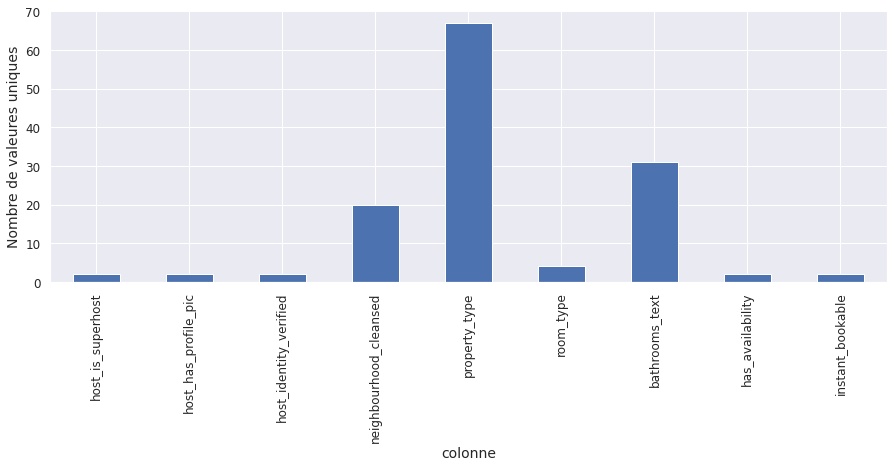

In [ ]:
# Calculer le nombre de valeurs uniques pour chaque colonne
num_unique_values = df_listings[categorical_var].apply(pd.Series.nunique, axis='rows')
print(num_unique_values)

# Ploter le number de valeurs uniques pour chaque colonne
num_unique_values.plot(kind='bar')
plt.xlabel('colonne')
plt.ylabel('Nombre de valeures uniques')
plt.show()

In [ ]:
# %%time
# fig = plt.figure(figsize=(15,5))
# g = sns.countplot(x='property_type', data=df_listings);
# fig.suptitle('Répartition des property_type des listings', fontsize=20)
# plt.xlabel('Les type du biens', fontsize=18)
# plt.ylabel('Nombre d\'observation', fontsize=16)
# plt.xticks(rotation=90)
# plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


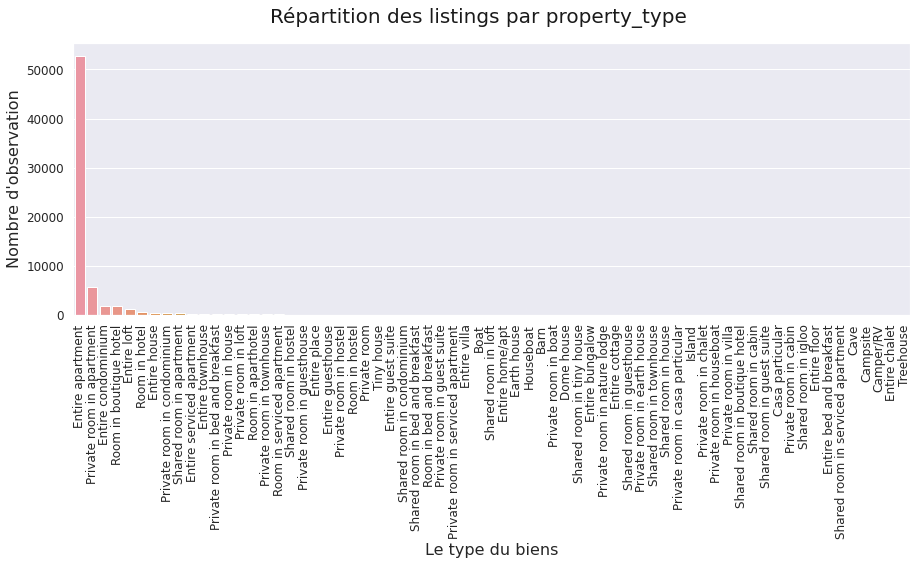

In [ ]:
aux = df_listings.property_type.value_counts().to_frame()
aux.columns=['number_obs']
aux.sort_values(by='number_obs', ascending=False, inplace=True)
x = [str(i) for i in aux.index]
y = [int(j) for j in aux.number_obs]
fig = plt.figure(figsize=(15,5))
plt.subplot(1,1,1);
g=sns.barplot(x, y)
fig.suptitle('Répartition des listings par property_type', fontsize=20)
plt.xlabel('Le type du biens', fontsize=16)
plt.ylabel('Nombre d\'observation', fontsize=16)
plt.xticks(rotation=90)
del aux
plt.show()

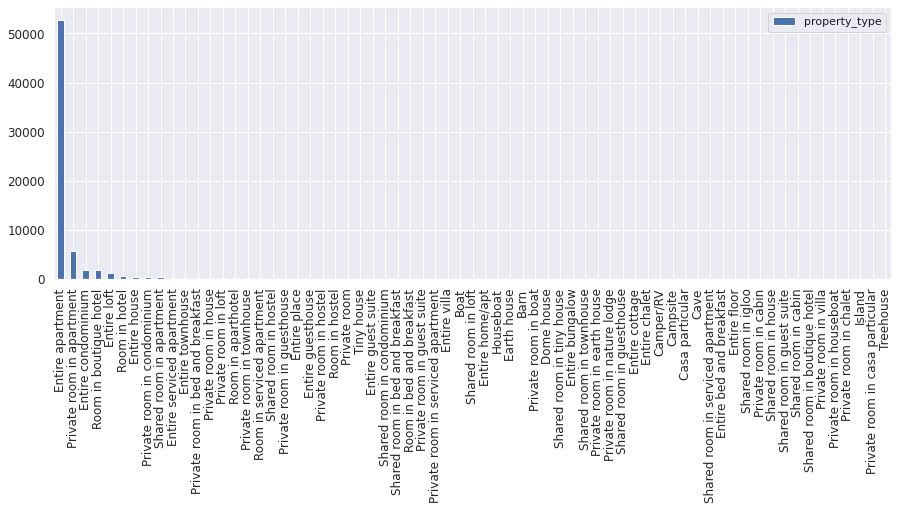

In [ ]:
df_listings[['property_type']].apply(pd.Series.value_counts).plot(kind='bar')

In [ ]:
missing_df = missing_statistics(df_listings)
missing_df

number_missing  \
review_scores_location                                 16971   
review_scores_value                                    16970   
review_scores_checkin                                  16970   
review_scores_accuracy                                 16953   
review_scores_communication                            16951   
review_scores_cleanliness                              16943   
review_scores_rating                                   16906   
last_review                                            15688   
reviews_per_month                                      15688   
bedrooms                                               13592   
beds                                                    2299   
description                                             1443   
host_location                                            174   
bathrooms_text                                           126   
name                                                      64   
price                                                     59   
host_has_profile_pic                                      28   
host_identity_verified                                    28   
host_total_listings_count                                 28   
host_listings_count                                       28   
host_is_superhost                                         28   
host_since                                                28   
instant_bookable                                           0   
number_of_reviews_ltm                                      0   
calculated_host_listings_count                             0   
calculated_host_listings_count_entire_homes                0   
calculated_host_listings_count_private_rooms               0   
calculated_host_listings_count_shared_rooms                0   
number_of_reviews_l30d                                     0   
listing_id                                                 0   
number_of_reviews                                          0   
availability_365                                           0   
availability_90                                            0   
availability_60                                            0   
availability_30                                            0   
has_availability                                           0   
minimum_nights                                             0   
amenities                                                  0   
accommodates                                               0   
room_type                                                  0   
property_type                                              0   
longitude                                                  0   
latitude                                                   0   
neighbourhood_cleansed                                     0   
host_verifications                                         0   
maximum_nights                                             0   

                                              percentage_missing  
review_scores_location                                      26.0  
review_scores_value                                         26.0  
review_scores_checkin                                       26.0  
review_scores_accuracy                                      26.0  
review_scores_communication                                 26.0  
review_scores_cleanliness                                   26.0  
review_scores_rating                                        26.0  
last_review                                                 24.0  
reviews_per_month                                           24.0  
bedrooms                                                    21.0  
beds                                                         3.0  
description                                                  2.0  
host_location                                                0.0  
bathrooms_text                                               0.0  
name                            

- Les valeurs manquantes pour les colonnes commençant par "host" semblent avoir un caractère récurrent. Comme toutes ces colonnes comportent 28 valeurs manquantes, il est possible que les données soient sans signification.

In [ ]:
# séléctionner toutes les colonnes qui ont des valeurs manquantes
cols_missing_values = list(missing_df[missing_df.number_missing > 0].index)
df_listings_missing_values = df_listings[cols_missing_values]
df_listings_missing_values.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65917 entries, 0 to 65916
Data columns (total 22 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   review_scores_location       48946 non-null  float64 
 1   review_scores_value          48947 non-null  float64 
 2   review_scores_checkin        48947 non-null  float64 
 3   review_scores_accuracy       48964 non-null  float64 
 4   review_scores_communication  48966 non-null  float64 
 5   review_scores_cleanliness    48974 non-null  float64 
 6   review_scores_rating         49011 non-null  float64 
 7   last_review                  50229 non-null  object  
 8   reviews_per_month            50229 non-null  float64 
 9   bedrooms                     52325 non-null  float64 
 10  beds                         63618 non-null  float64 
 11  description                  64474 non-null  object  
 12  host_location                65743 non-null  object  
 13  b

In [ ]:
# Selectionner que les colonne avec un nom qui contient la chine "host"
host_cols = list(df_listings_missing_values.columns[df_listings_missing_values.columns.str.contains('host')])
# Slectionner toutes les lignes de la liste de ces colonnes(host_cols) ou host_has_profile_pic est null
df_listings_missing_values[host_cols][df_list                                                                                                                                                                                                                                                                   ings_missing_values.host_has_profile_pic.isnull()]

host_location host_has_profile_pic host_identity_verified  \
971             NaN                  NaN                    NaN   
3791            NaN                  NaN                    NaN   
8104            NaN                  NaN                    NaN   
8246            NaN                  NaN                    NaN   
8413            NaN                  NaN                    NaN   
8752            NaN                  NaN                    NaN   
9000            NaN                  NaN                    NaN   
9937            NaN                  NaN                    NaN   
10150           NaN                  NaN                    NaN   
11536           NaN                  NaN                    NaN   
11743           NaN                  NaN                    NaN   
12634           NaN                  NaN                    NaN   
13351           NaN                  NaN                    NaN   
13360           NaN                  NaN                    NaN   
13365           NaN                  NaN                    NaN   
13374           NaN                  NaN                    NaN   
14333           NaN                  NaN                    NaN   
14499           NaN                  NaN                    NaN   
14566           NaN                  NaN                    NaN   
22761           NaN                  NaN                    NaN   
25714           NaN                  NaN                    NaN   
26292           NaN                  NaN                    NaN   
33583           NaN                  NaN                    NaN   
36251           NaN                  NaN                    NaN   
40654           NaN                  NaN                    NaN   
46902           NaN                  NaN                    NaN   
64393           NaN                  NaN                    NaN   
65311           NaN                  NaN                    NaN   

       host_total_listings_count  host_listings_count host_is_superhost  \
971                          NaN                  NaN               NaN   
3791                         NaN                  NaN               NaN   
8104                         NaN                  NaN               NaN   
8246                         NaN                  NaN               NaN   
8413                         NaN                  NaN               NaN   
8752                         NaN                  NaN               NaN   
9000                         NaN                  NaN               NaN   
9937                         NaN                  NaN               NaN   
10150                        NaN                  NaN               NaN   
11536                        NaN                  NaN               NaN   
11743                        NaN                  NaN               NaN   
12634                        NaN                  NaN               NaN   
13351                        NaN                  NaN               NaN   
13360                        NaN                  NaN               NaN   
13365                        NaN                  NaN               NaN   
13374                        NaN                  NaN               NaN   
14333                        NaN                  NaN               NaN   
14499                        NaN                  NaN               NaN   
14566                        NaN                  NaN               NaN   
22761                        NaN                  NaN               NaN   
25714                        NaN                  NaN               NaN   
26292                        NaN                  NaN               NaN   
33583                        NaN                  NaN               NaN   
36251                        NaN                  NaN               NaN   
40654                        NaN                  NaN               NaN   
46902                        NaN                  NaN               NaN   
64393                        NaN     

In [ ]:
df_listings_missing_values.shape

(65917, 22)

##Traitement des valeurs manquantes
- Pour les colonnes contenant du texte, il faut les remplacer par une chaîne vide.
- Pour les colonnes catégorielles, il faut les remplacer par le mode.
- Pour les colonnes continues, il faut les remplacer par la médiane.
- J'utiliserai SimpleImputer de Sklearn pour remplacer les valeurs manquantes.

In [ ]:
df_listings.head(3)

listing_id                                 name  \
0        2577     Loft for 4 by Canal Saint Martin   
1        3109                         zen and calm   
2        4890  Quiet Historic & Cute  +Free Cruise   

                                         description  host_since  \
0  100 m2 loft (1100 sq feet) with high ceiling, ...  2008-09-09   
1  <b>The space</b><br />I bedroom appartment in ...  2008-10-14   
2  Stylish & Classic One bedroom apartment for up...  2009-01-16   

                           host_location host_is_superhost  \
0  Casablanca, Grand Casablanca, Morocco                 f   
1           Paris, Île-de-France, France                 f   
2           Paris, Île-de-France, France                 f   

   host_listings_count  host_total_listings_count  \
0                  2.0                        2.0   
1                  1.0                        1.0   
2                  9.0                        9.0   

                                  host_verifications host_has_profile_pic  \
0  ['email', 'phone', 'reviews', 'jumio', 'govern...                    t   
1          ['email', 'phone', 'facebook', 'reviews']                    t   
2  ['email', 'phone', 'reviews', 'offline_governm...                    t   

  host_identity_verified neighbourhood_cleansed  latitude  longitude  \
0                      t               Entrepôt  48.86993    2.36251   
1                      f           Observatoire  48.83349    2.31852   
2                      t                 Temple  48.86409    2.35651   

      property_type        room_type  accommodates bathrooms_text  bedrooms  \
0       Entire loft  Entire home/apt             4        2 baths       2.0   
1  Entire apartment  Entire home/apt             2         1 bath       NaN   
2  Entire apartment  Entire home/apt             4         1 bath       1.0   

   beds                                          amenities  price  \
0   2.0  ["Dryer", "Host greets you", "Hot water", "Han...  125.0   
1   1.0  ["Children\u2019s books and toys", "Paid parki...   60.0   
2   2.0  ["Dryer", "Host greets you", "Hangers", "Iron"...   69.0   

   minimum_nights  maximum_nights has_availability  availability_30  \
0               3            1125                t               30   
1               2              30                t                2   
2               5             120                t                8   

   availability_60  availability_90  availability_365  number_of_reviews  \
0               60               90               364                  1   
1                2                2                 2                  9   
2               37               67                67                 23   

   number_of_reviews_ltm  number_of_reviews_l30d last_review  \
0                      0                       0  2019-01-02   
1                      0                       0  2019-10-24   
2                      1                       0  2020-09-07   

   review_scores_rating  review_scores_accuracy  review_scores_cleanliness  \
0                 100.0                    10.0                       10.0   
1                 100.0                    10.0                       10.0   
2                  95.0                    10.0                        9.0   

   review_scores_checkin  review_scores_communication  review_scores_location  \
0                   10.0                         10.0                    10.0   
1                   10.0                         10.0                    10.0   
2                   10.0                         10.0                    10.0   

   review_scores_value instant_bookable  calculated_host_listings_count  \
0                 10.0                f                               1   
1                 10.0                f                               1   
2                 10.0                f                              14   

   calculated_host_listings_count_entire_homes  \
0                      

In [ ]:
df_listings.shape

(65917, 46)

###Colonne: Text

In [ ]:
df_listings.loc[df_listings.name.isna(), 'name'] = ''
df_listings.loc[df_listings.description.isna(), 'description'] = ''
# df_listings.loc[df_listings.name.isna(), 'host_name'] = ''
df_listings.loc[df_listings.host_location.isna(), 'host_location'] = ''

In [ ]:
type(df_listings.host_since[0]) == type(df_listings.last_review[0]) == str

True

In [ ]:
df_listings.host_since

0        2008-09-09
1        2008-10-14
2        2009-01-16
3        2009-02-14
4        2008-08-30
            ...    
65912    2020-11-10
65913    2018-07-23
65914    2018-05-08
65915    2016-05-16
65916    2014-02-28
Name: host_since, Length: 65917, dtype: object

- Ces deux colonnes seront utulisées que pour faire des visualisations et pas pour lanalyse ou la prédiction parce qu'elles contiennent des valeures manquantes

In [ ]:
df_listings.loc[df_listings.host_since.isna(), 'host_since'] = ''
df_listings.loc[df_listings.last_review.isna(), 'last_review'] = ''

###Colonne: catégorielles

In [ ]:
df_listings.has_availability.value_counts()

t    65820
f       97
Name: has_availability, dtype: int64

In [ ]:
categorical_var 

['host_is_superhost',
 'host_has_profile_pic',
 'host_identity_verified',
 'neighbourhood_cleansed',
 'property_type',
 'room_type',
 'bathrooms_text',
 'has_availability',
 'instant_bookable']

In [ ]:
# séléctionner les colonnes catégorielles avec des valeures manquantes
[cat_col for cat_col in categorical_var if missing_df.loc[cat_col, 'number_missing'] >0]

['host_is_superhost',
 'host_has_profile_pic',
 'host_identity_verified',
 'bathrooms_text']

In [ ]:
category_missing_cols = ['host_is_superhost','host_has_profile_pic', 
                         'host_identity_verified', 'bathrooms_text']

###Colonne: float

In [ ]:
# séléctionner les colonnes float avec des valeures manquantes
float_var = df_listings.select_dtypes(include=['float64']).columns
float_var

Index(['host_listings_count', 'host_total_listings_count', 'latitude',
       'longitude', 'bedrooms', 'beds', 'price', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'reviews_per_month'],
      dtype='object')

In [ ]:
[float_col for float_col in float_var if missing_df.loc[float_col, 'number_missing'] >0]

['host_listings_count',
 'host_total_listings_count',
 'bedrooms',
 'beds',
 'price',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'reviews_per_month']

In [ ]:
# Séléctionner toutes les colonne de type float et qui contiennet des 
# valeures manquantes
float_missing_cols = ['host_listings_count',
                      'host_total_listings_count',
                      'bedrooms',
                      'beds',
                      'price',
                      'review_scores_rating',
                      'review_scores_accuracy',
                      'review_scores_cleanliness',
                      'review_scores_checkin',
                      'review_scores_communication',
                      'review_scores_location',
                      'review_scores_value',
                      'reviews_per_month'
                      ]

In [ ]:
# index,_ = np.where(df_listings[float_missing_cols].isna() == True)
# df_listings.iloc[index, :]

In [ ]:
category_missing_cols + float_missing_cols

['host_is_superhost',
 'host_has_profile_pic',
 'host_identity_verified',
 'bathrooms_text',
 'host_listings_count',
 'host_total_listings_count',
 'bedrooms',
 'beds',
 'price',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'reviews_per_month']

In [ ]:
def replace_missing_values(cols, df):
  '''
  Prend une liste de colonnes et un dataframe et impute en fonction du type de colonne. S'il s'agit d'un type d'objet, la valeur most_frequent est utilisée pour l'imputation. S'il s'agit d'un type float/int, alors la valeur médiane est utilisée pour l'imputation.
  arguments :
       cols : liste de colonnes
       df : dataframe contenant ces colonnes.
  retourne :
       df : le dataframe imputé
  '''
  for col in cols:
    if type(df[col].dtype) is pd.core.dtypes.dtypes.CategoricalDtype:
      print("Imputer la colonne {} avec la valeure la plus fréquente".format(col))
      mode_imputer = SimpleImputer(strategy='most_frequent')
      df.loc[:, col] = mode_imputer.fit_transform(df[[col]])
    elif df[col].dtype == 'float64' or df[col].dtype == 'int64':
      print("Imputer la colonne {} avec la valeure de la medianne".format(col))
      median_imputer = SimpleImputer(strategy='median')
      df.loc[:, col] = median_imputer.fit_transform(df[[col]])
    else:
      raise ValueError("Type de la colonne non valide!") 
  return df

In [ ]:
df_listings_clean = replace_missing_values(float_missing_cols, df_listings)

Imputer la colonne host_listings_count avec la valeure de la medianne
Imputer la colonne host_total_listings_count avec la valeure de la medianne
Imputer la colonne bedrooms avec la valeure de la medianne
Imputer la colonne beds avec la valeure de la medianne
Imputer la colonne price avec la valeure de la medianne
Imputer la colonne review_scores_rating avec la valeure de la medianne
Imputer la colonne review_scores_accuracy avec la valeure de la medianne
Imputer la colonne review_scores_cleanliness avec la valeure de la medianne
Imputer la colonne review_scores_checkin avec la valeure de la medianne
Imputer la colonne review_scores_communication avec la valeure de la medianne
Imputer la colonne review_scores_location avec la valeure de la medianne
Imputer la colonne review_scores_value avec la valeure de la medianne
Imputer la colonne reviews_per_month avec la valeure de la medianne


==> la colonne **`price`** est bien imputée a ce niveau

In [ ]:
df_listings_clean = replace_missing_values(category_missing_cols, df_listings)

Imputer la colonne host_is_superhost avec la valeure la plus fréquente
Imputer la colonne host_has_profile_pic avec la valeure la plus fréquente
Imputer la colonne host_identity_verified avec la valeure la plus fréquente
Imputer la colonne bathrooms_text avec la valeure la plus fréquente


In [ ]:
df_listings_clean.isna().sum()

listing_id                                      0
name                                            0
description                                     0
host_since                                      0
host_location                                   0
host_is_superhost                               0
host_listings_count                             0
host_total_listings_count                       0
host_verifications                              0
host_has_profile_pic                            0
host_identity_verified                          0
neighbourhood_cleansed                          0
latitude                                        0
longitude                                       0
property_type                                   0
room_type                                       0
accommodates                                    0
bathrooms_text                                  0
bedrooms                                        0
beds                                            0


In [ ]:
df_listings_clean.room_type.value_counts()

Entire home/apt    56593
Private room        7512
Hotel room          1393
Shared room          419
Name: room_type, dtype: int64

#Visualisations

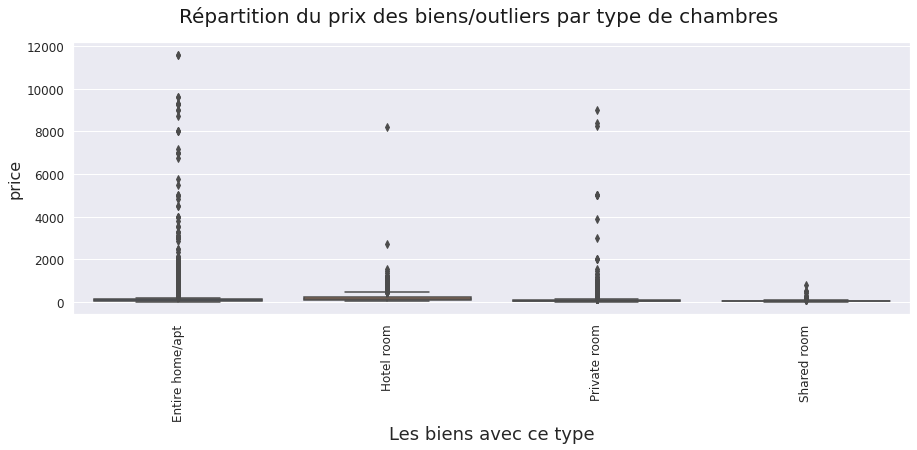

CPU times: user 249 ms, sys: 4.83 ms, total: 254 ms
Wall time: 259 ms


In [ ]:
%%time
fig = plt.figure(figsize=(15,5))
g=sns.boxplot(x='room_type', y='price',data=df_listings_clean)
fig.suptitle('Répartition du prix des biens/outliers par type de chambres', fontsize=20)
plt.xlabel('Les biens avec ce type', fontsize=18)
plt.ylabel('price', fontsize=16)
plt.xticks(rotation=90)
plt.show()

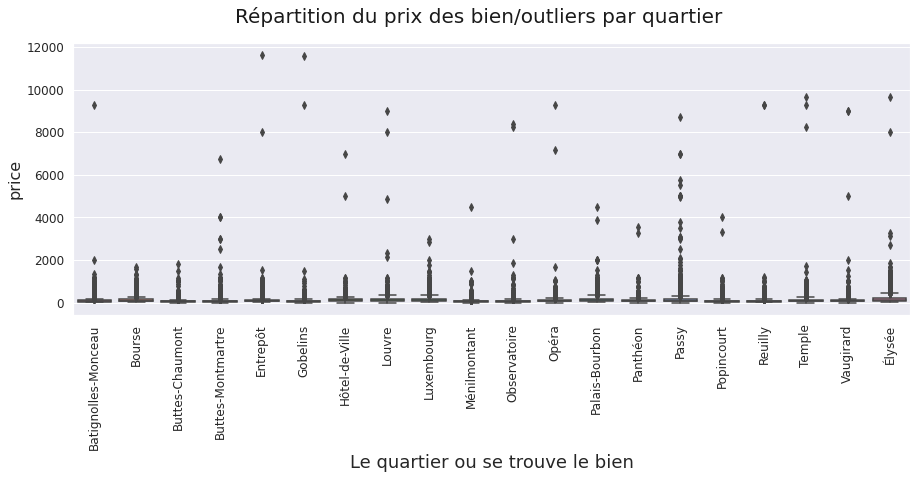

CPU times: user 535 ms, sys: 15.6 ms, total: 550 ms
Wall time: 557 ms


In [ ]:
%%time
fig = plt.figure(figsize=(15,5))
g=sns.boxplot(x='neighbourhood_cleansed', y='price',data=df_listings_clean)
fig.suptitle('Répartition du prix des bien/outliers par quartier', fontsize=20)
plt.xlabel('Le quartier ou se trouve le bien', fontsize=18)
plt.ylabel('price', fontsize=16)
plt.xticks(rotation=90)
plt.show()

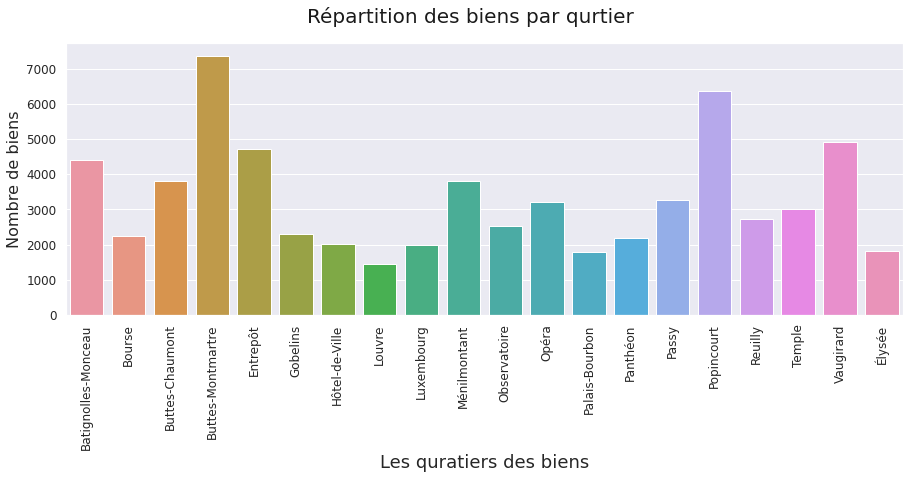

CPU times: user 360 ms, sys: 6.96 ms, total: 367 ms
Wall time: 370 ms


In [ ]:
%%time
fig = plt.figure(figsize=(15,5))
g = sns.countplot(x='neighbourhood_cleansed', data=df_listings_clean);
fig.suptitle('Répartition des biens par qurtier', fontsize=20)
plt.xlabel('Les quratiers des biens', fontsize=18)
plt.ylabel('Nombre de biens', fontsize=16)
plt.xticks(rotation=90)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


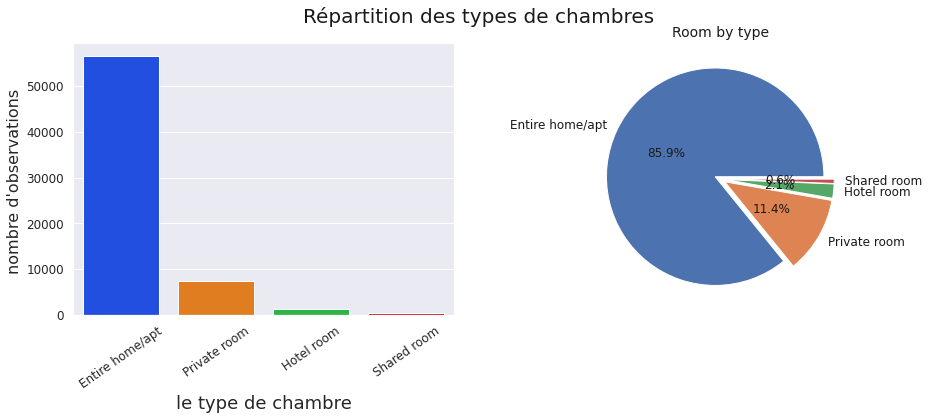

In [ ]:
aux = df_listings_clean.room_type.value_counts()
x = [str(i) for i in aux.index]
fig = plt.figure(figsize=(15,5))
plt.subplot(1,2,1);
g=sns.barplot(x, y=list(aux), palette="bright")
fig.suptitle('Répartition des types de chambres', fontsize=20)
plt.xlabel('le type de chambre', fontsize=18)
plt.ylabel('nombre d\'observations ', fontsize=16)
plt.xticks(rotation=35)
plt.subplot(1,2,2);
plt.pie(x=list(aux), autopct="%.1f%%", explode=[0.05]*4, labels=x, pctdistance=0.5)
plt.title("Room by type", fontsize=14);
del aux
plt.show()

CPU times: user 199 ms, sys: 3.93 ms, total: 202 ms
Wall time: 215 ms


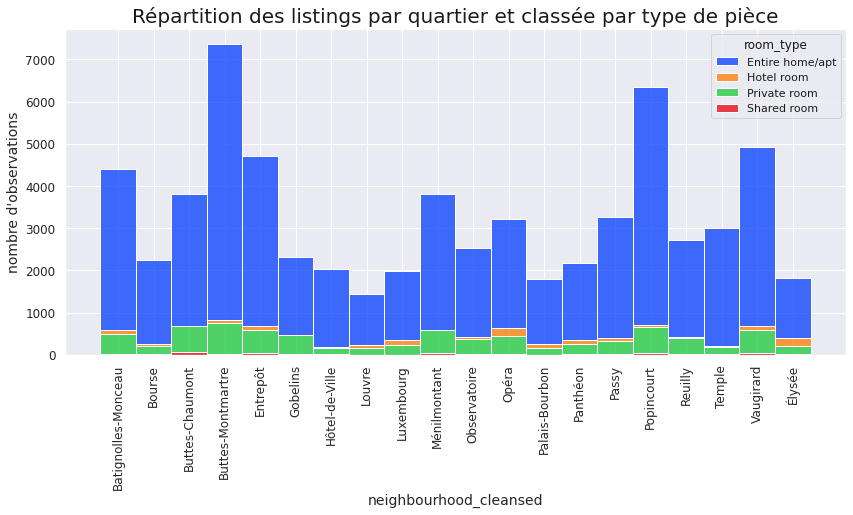

In [ ]:
%%time
f = plt.figure(figsize=(14,6))
ax = f.add_subplot(1,1,1)
sns.histplot(data=df_listings_clean, ax=ax, stat="count", multiple="stack",
             x="neighbourhood_cleansed", kde=False,
             palette="bright", hue="room_type",
             element="bars", legend=True)
ax.set_title("Répartition des listings par quartier et classée par type de pièce",fontsize=20)
ax.set_xlabel("neighbourhood_cleansed")
ax.set_ylabel("nombre d'observations")
plt.xticks(rotation=90)

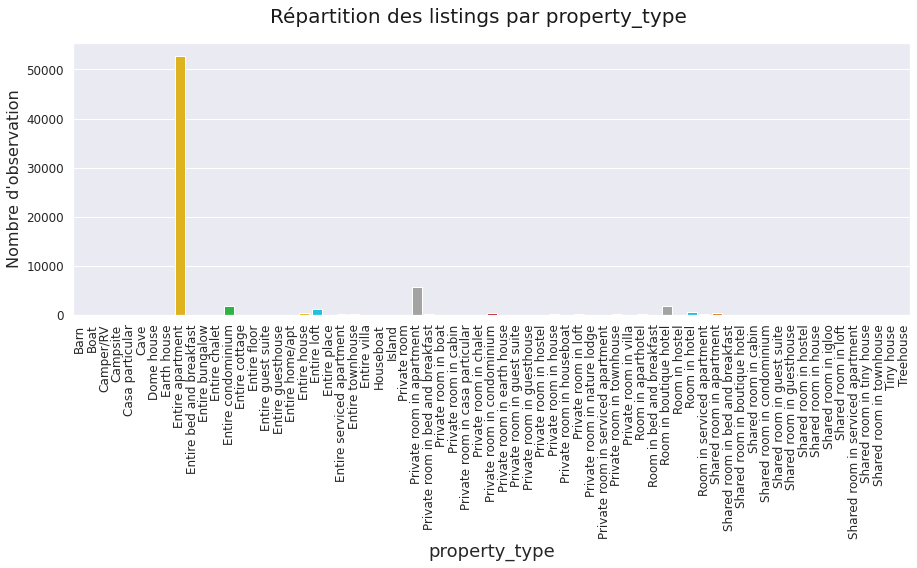

CPU times: user 2.52 s, sys: 304 ms, total: 2.83 s
Wall time: 2.83 s


In [ ]:
%%time
fig = plt.figure(figsize=(15,5))
g = sns.countplot(x='property_type', data=df_listings_clean, palette="bright");
fig.suptitle('Répartition des listings par property_type', fontsize=20)
plt.xlabel('property_type', fontsize=18)
plt.ylabel('Nombre d\'observation', fontsize=16)
plt.xticks(rotation=90)
plt.show()

CPU times: user 422 ms, sys: 15 ms, total: 437 ms
Wall time: 443 ms


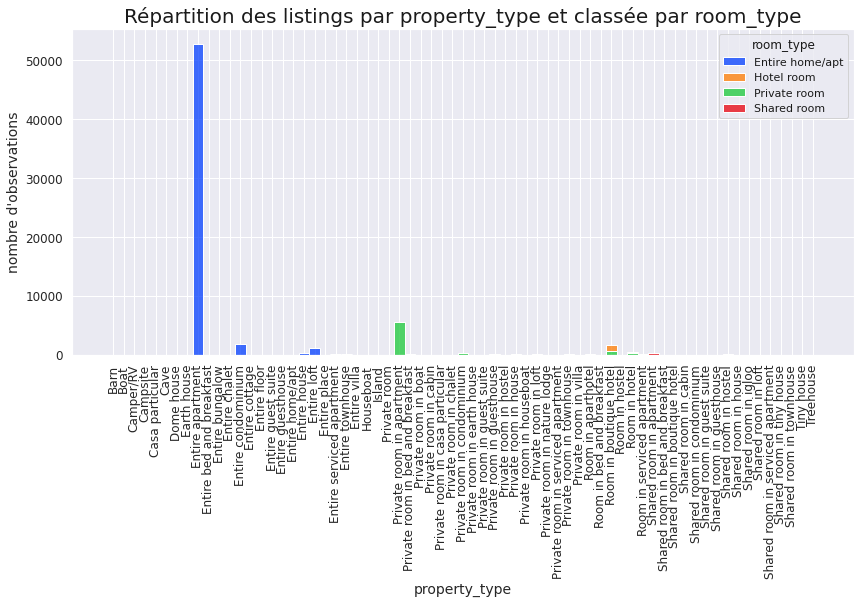

In [ ]:
%%time
aux = df_listings_clean.copy()
aux['count'] = aux.groupby('property_type')['property_type'].transform('count')
aux.sort_values(by='count', ascending=False, inplace=True)

f = plt.figure(figsize=(14,6))
ax = f.add_subplot(1,1,1)
sns.histplot(data=aux, ax=ax, stat="count", multiple="stack",
             x="property_type", kde=False, 
             palette="bright", hue="room_type",
             element="bars", legend=True)
ax.set_title("Répartition des listings par property_type et classée par room_type",fontsize=20)
ax.set_xlabel("property_type")
ax.set_ylabel("nombre d'observations")
del aux
plt.xticks(rotation=90)

In [ ]:
len(df_listings_clean.accommodates.value_counts())

17

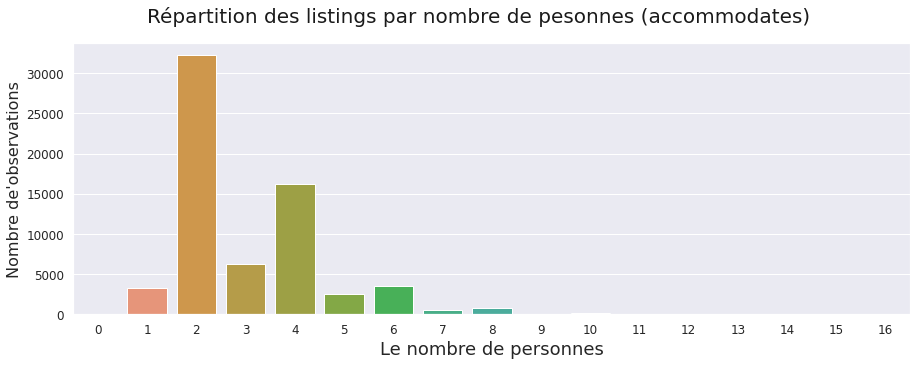

CPU times: user 343 ms, sys: 4.74 ms, total: 347 ms
Wall time: 354 ms


In [ ]:
%%time
aux = df_listings_clean.accommodates.value_counts().sort_index()
fig = plt.figure(figsize=(15,5))
g = sns.countplot(x='accommodates', data=df_listings_clean);
fig.suptitle('Répartition des listings par nombre de pesonnes (accommodates)', fontsize=20)
plt.xlabel('Le nombre de personnes', fontsize=18)
plt.ylabel('Nombre de\'observations', fontsize=16)
plt.xticks(rotation=0)
plt.show()
del aux

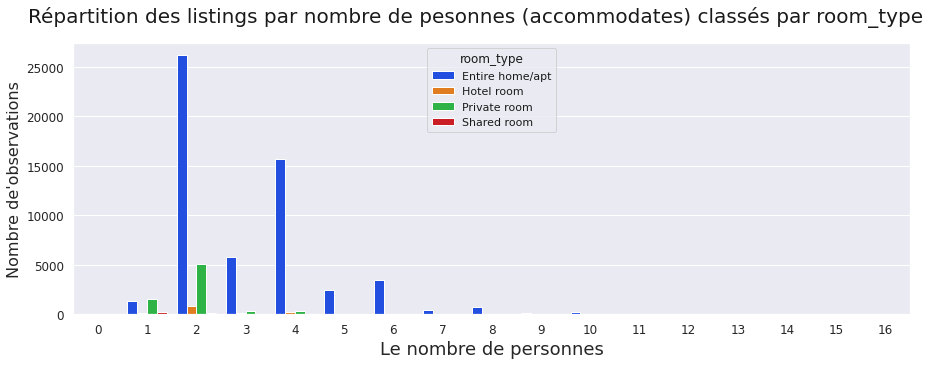

CPU times: user 654 ms, sys: 3.91 ms, total: 658 ms
Wall time: 660 ms


In [ ]:
%%time
fig = plt.figure(figsize=(15,5))
g = sns.countplot(x='accommodates', data=df_listings_clean,  palette="bright", hue="room_type");
fig.suptitle('Répartition des listings par nombre de pesonnes (accommodates) classés par room_type ', fontsize=20)
plt.xlabel('Le nombre de personnes', fontsize=18)
plt.ylabel('Nombre de\'observations', fontsize=16)
plt.xticks(rotation=0)
plt.show()

CPU times: user 531 ms, sys: 11.8 ms, total: 543 ms
Wall time: 545 ms


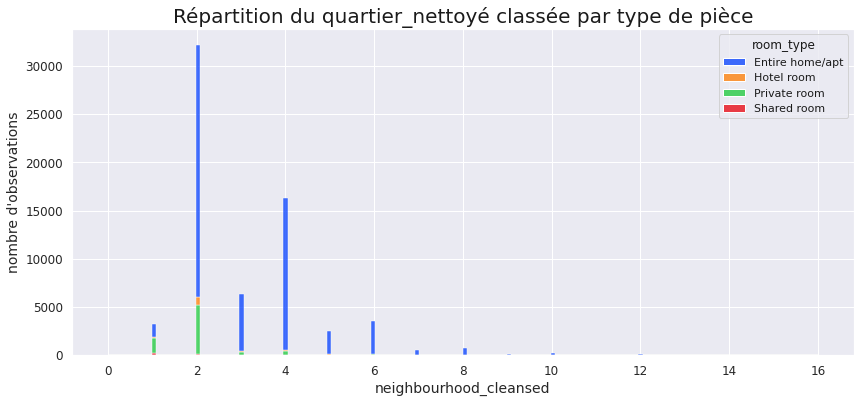

In [ ]:
%%time
f = plt.figure(figsize=(14,6))
ax = f.add_subplot(1,1,1)
sns.histplot(data=df_listings_clean, ax=ax, stat="count", multiple="stack",
             x="accommodates", kde=False,
             palette="bright", hue="room_type",
             element="bars", legend=True)
ax.set_title("Répartition du quartier_nettoyé classée par type de pièce", fontsize=20)
ax.set_xlabel("neighbourhood_cleansed")
ax.set_ylabel("nombre d'observations")
# plt.xticks(rotation=90)

#Feature Engineering

- **id:** identifiant de la listing qui peut être utilisé pour créer une jointure avec d'autres datasets



### **last_review**: ce champ servira à filtrer les listes qui ne sont plus actives

In [ ]:
df_listings_clean[['last_review']].isnull().sum()

last_review    0
dtype: int64

In [ ]:
df_listings_clean.last_review.value_counts()

              15688
2020-01-02      511
2020-01-01      468
2020-03-01      436
2020-03-15      410
              ...  
2012-10-09        1
2015-04-19        1
2015-04-16        1
2020-04-28        1
2014-07-23        1
Name: last_review, Length: 2305, dtype: int64

- conversion de type de la variable last_review des str a timestamp

In [ ]:
reviews_year = []
reviews_month =[]
for date in df_listings_clean.last_review:
    try:
      reviews_year.append((pd.to_datetime(date, format='%Y-%m-%d')).year)
      reviews_month.append((pd.to_datetime(date, format='%Y-%m-%d')).month)
    except ValueError:
      print("[Oops!] %s There was not a valid datetime value. '2000' will be used for this row..."%date)
      datetime.append(pd.to_datetime('2000-01-01'))
      reviews_year.append(2000)
      reviews_year.append(1)


In [ ]:
len(reviews_year) == len(reviews_month) == df_listings_clean.shape[0]

True

In [ ]:
df_listings_clean['last_review_year'] = reviews_year
df_listings_clean['last_review_month'] = reviews_month

In [ ]:
df_listings_clean['last_review_year'].isna().sum()

15688

In [ ]:
df_listings_clean[df_listings_clean['last_review_year']==2011]

listing_id                               name  \
30        19150  LOVELY  APARTMENT NEAR MONTMARTRE   
123       69269               Saint Germain Studio   
195      156649       Private Room - Pere Lachaise   

                                           description  host_since  \
30   <b>The space</b><br />52m2 (560 square ft), on...  2010-01-18   
123  <b>The space</b><br />St-Germain-des-Prés <br ...  2011-01-13   
195  <b>The space</b><br />Very confortable Private...  2010-08-22   

                         host_location host_is_superhost  host_listings_count  \
30   Longjumeau, Ile-de-France, France                 f                  1.0   
123             Paris - Miami - Panama                 f                  1.0   
195                                 BR                 f                  1.0   

     host_total_listings_count  \
30                         1.0   
123                        1.0   
195                        1.0   

                                    host_verifications host_has_profile_pic  \
30   ['email', 'phone', 'reviews', 'manual_offline'...                    t   
123  ['email', 'phone', 'reviews', 'jumio', 'offlin...                    f   
195                                          ['email']                    f   

    host_identity_verified neighbourhood_cleansed  latitude  longitude  \
30                       t      Buttes-Montmartre  48.88565    2.35906   
123                      t         Palais-Bourbon  48.85499    2.32452   
195                      f             Popincourt  48.86311    2.38591   

                 property_type        room_type  accommodates bathrooms_text  \
30            Entire apartment  Entire home/apt             3         1 bath   
123           Entire apartment  Entire home/apt             3         1 bath   
195  Private room in apartment     Private room             2         1 bath   

     bedrooms  beds                                          amenities  price  \
30        1.0   2.0           ["Kitchen", "Washer", "Wifi", "Heating"]   80.0   
123       1.0   2.0  ["Air conditioning", "Wifi", "Cable TV", "Heat...  136.0   
195       1.0   1.0  ["Indoor fireplace", "Elevator", "Wifi", "Cabl...   89.0   

     minimum_nights  maximum_nights has_availability  availability_30  \
30                3              14                t               14   
123               2             730                t               30   
195               2             730                t               30   

     availability_60  availability_90  availability_365  number_of_reviews  \
30                44               74               349                  2   
123               60               90               365                  1   
195               60               90               365                  1   

     number_of_reviews_ltm  number_of_reviews_l30d last_review  \
30                       0                       0  2011-06-27   
123                      0                       0  2011-03-16   
195                      0                       0  2011-06-29   

     review_scores_rating  review_scores_accuracy  review_scores_cleanliness  \
30                   90.0                    10.0                        8.0   
123                  80.0                    10.0                        8.0   
195                  95.0                    10.0                        9.0   

     review_scores_checkin  review_scores_communication  \
30                    10.0                         10.0   
123                    6.0                          8.0   
195                   10.0                         10.0   

     review_scores_location  review_scores_value instant_bookable  \
30                      8.0                  8.0                f   
123                    10.0                 10.0                f   
195                    10.0                  9.0                f   

     calculated_host_listings_count  \
30                                1   
1

In [ ]:
df_listings_clean.last_review_year.value_counts()

2020.0    24302
2019.0    12804
2018.0     4854
2017.0     3634
2016.0     2826
2015.0     1544
2014.0      198
2013.0       44
2012.0       19
2011.0        3
2010.0        1
Name: last_review_year, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


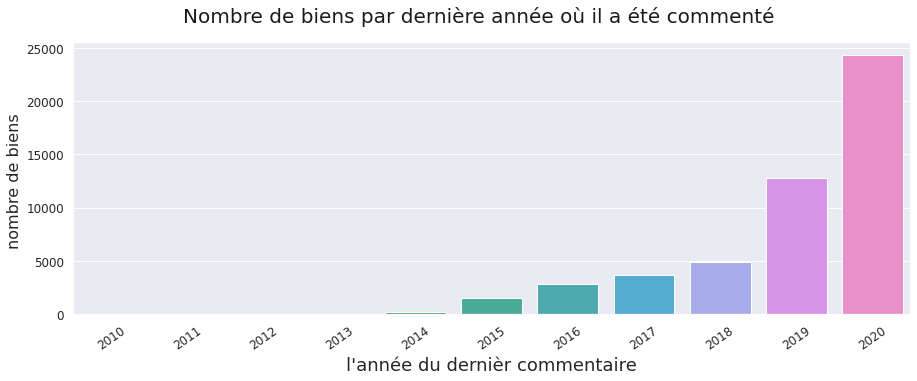

CPU times: user 280 ms, sys: 3.95 ms, total: 284 ms
Wall time: 286 ms


In [ ]:
%%time
aux = df_listings_clean.last_review_year.value_counts()
x = [int(i) for i in aux.index]
fig = plt.figure(figsize=(15,5))
g=sns.barplot(x, y=list(aux))
fig.suptitle('Nombre de biens par dernière année où il a été commenté', fontsize=20)
plt.xlabel('l\'année du dernièr commentaire', fontsize=18)
plt.ylabel('nombre de biens ', fontsize=16)
plt.xticks(rotation=35)
plt.show()
del aux

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


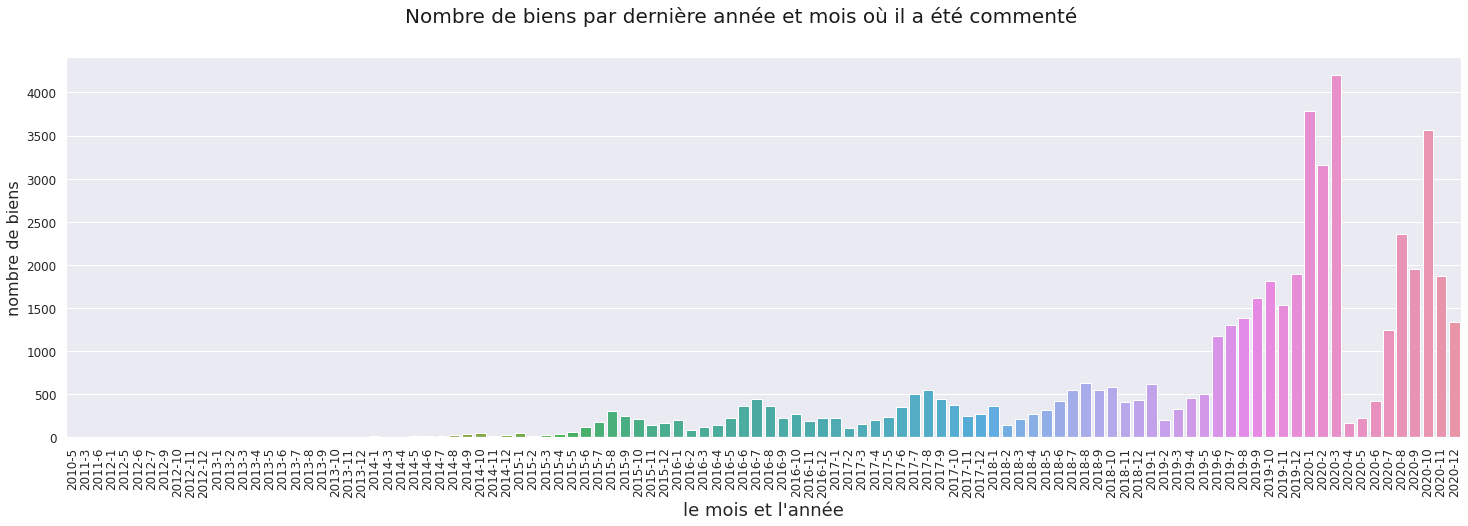

CPU times: user 2.97 s, sys: 225 ms, total: 3.2 s
Wall time: 3.2 s


In [ ]:
%%time
aux = df_listings_clean.groupby(['last_review_year', 'last_review_month']).size()
x = [str(int(i[0]))+"-"+str(int(i[1])) for i in aux.index]
fig = plt.figure(figsize=(25,7))
g=sns.barplot(x, y=aux)
fig.suptitle('Nombre de biens par dernière année et mois où il a été commenté', fontsize=20)
plt.xlabel('le mois et l\'année', fontsize=18)
plt.ylabel('nombre de biens', fontsize=16)
plt.xticks(rotation=90)
plt.show()
del aux

In [ ]:
df_listings_clean[df_listings_clean.last_review_year == 2010].head(5)

listing_id                                 name  \
16       12268  Faubourg Saint Antoine-chambrecalme   

                                          description  host_since  \
16  <b>The space</b><br />Chambre très claire, cal...  2009-10-20   

                   host_location host_is_superhost  host_listings_count  \
16  Paris, Ile-de-France, France                 f                  2.0   

    host_total_listings_count             host_verifications  \
16                        2.0  ['email', 'phone', 'reviews']   

   host_has_profile_pic host_identity_verified neighbourhood_cleansed  \
16                    t                      f             Popincourt   

    latitude  longitude              property_type     room_type  \
16   48.8509    2.38695  Private room in apartment  Private room   

    accommodates bathrooms_text  bedrooms  beds  \
16             2         1 bath       1.0   1.0   

                                            amenities  price  minimum_nights  \
16  ["Breakfast", "Washer", "Heating", "Elevator",...   60.0               6   

    maximum_nights has_availability  availability_30  availability_60  \
16              40                t                0                0   

    availability_90  availability_365  number_of_reviews  \
16                0                 0                  1   

    number_of_reviews_ltm  number_of_reviews_l30d last_review  \
16                      0                       0  2010-05-28   

    review_scores_rating  review_scores_accuracy  review_scores_cleanliness  \
16                  95.0                    10.0                        9.0   

    review_scores_checkin  review_scores_communication  \
16                   10.0                         10.0   

    review_scores_location  review_scores_value instant_bookable  \
16                    10.0                  9.0                f   

    calculated_host_listings_count  \
16                               2   

    calculated_host_listings_count_entire_homes  \
16                                            1   

    calculated_host_listings_count_private_rooms  \
16                                             1   

    calculated_host_listings_count_shared_rooms  reviews_per_month  \
16                                            0               0.01   

    last_review_year  last_review_month  
16            2010.0                5.0

- Ces deux colonnes sont utilisées que pour les graphoques, aprés je l'ai supprimé.

In [ ]:
df_listings_clean.drop(['last_review_year', 'last_review_month'], axis=1, inplace = True)
df_listings_clean.columns

Index(['listing_id', 'name', 'description', 'host_since', 'host_location',
       'host_is_superhost', 'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood_cleansed', 'latitude', 'longitude', 'property_type',
       'room_type', 'accommodates', 'bathrooms_text', 'bedrooms', 'beds',
       'amenities', 'price', 'minimum_nights', 'maximum_nights',
       'has_availability', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'number_of_reviews',
       'number_of_reviews_ltm', 'number_of_reviews_l30d', 'last_review',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'instant_bookable',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_h

### **host_location**: nous pouvons l'utiliser pour déterminer si l'hôte est local ou non


In [ ]:
df_listings_clean.host_location.isna().sum()

0

In [ ]:
df_listings_clean.host_location.value_counts()

Paris, Île-de-France, France                              47966
FR                                                         8419
London, England, United Kingdom                             454
France                                                      421
Paris, Ile-de-France, France                                277
                                                          ...  
on this planet                                                1
Belleville-en-Beaujolais, Auvergne-Rhône-Alpes, France        1
Liancourt, Nord-Pas-de-Calais-Picardie, France                1
La Chabossière, Pays De La Loire, France                      1
Bourbon-l'Archambault, Auvergne, France                       1
Name: host_location, Length: 2237, dtype: int64

In [ ]:
df_listings_clean['host_local'] = df_listings_clean.host_location.str.contains('France|FRANCE|france|FR|fr|Fr').astype(int)

In [ ]:
df_listings_clean.loc[:,['host_location','host_local']]

host_location  host_local
0      Casablanca, Grand Casablanca, Morocco           0
1               Paris, Île-de-France, France           1
2               Paris, Île-de-France, France           1
3                 Istanbul, İstanbul, Turkey           0
4               Paris, Île-de-France, France           1
...                                      ...         ...
65912                                     FR           1
65913                                     FR           1
65914                                     FR           1
65915           Paris, Île-de-France, France           1
65916           Paris, Île-de-France, France           1

[65917 rows x 2 columns]

In [ ]:
df_listings_clean.host_local.value_counts()

1    62027
0     3890
Name: host_local, dtype: int64

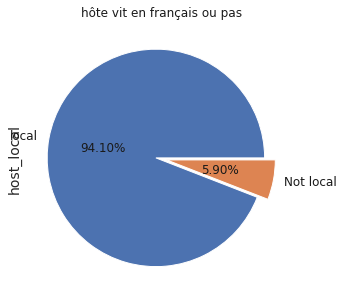

In [ ]:
aux = df_listings_clean.host_local.replace(to_replace = [0,1],value = ['Not local','local'])
aux.value_counts().plot.pie(autopct='%.2f%%',  explode=[0.05]*2, pctdistance=0.5, title='hôte vit en français ou pas')
# del aux

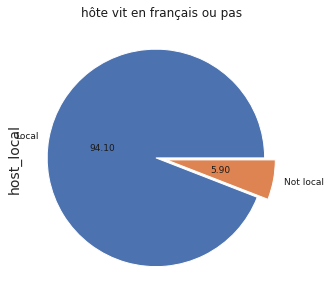

In [ ]:
# plot = df_listings_clean.plot.pie(y='host_local', figsize=(5, 5))
# df_listings_clean.host_local.value_counts().plot.pie(autopct="%.1f%%");
df_listings_clean['host_local'].value_counts().plot(kind='pie', autopct='%.2f', 
                                                   explode=[0.05]*2, pctdistance=0.5,
                                                   labels=['Local','Not local'],
                                                   title='hôte vit en français ou pas',
                                                   figsize=(15,5),
                                                   fontsize=9)

CPU times: user 203 ms, sys: 2.98 ms, total: 206 ms
Wall time: 208 ms


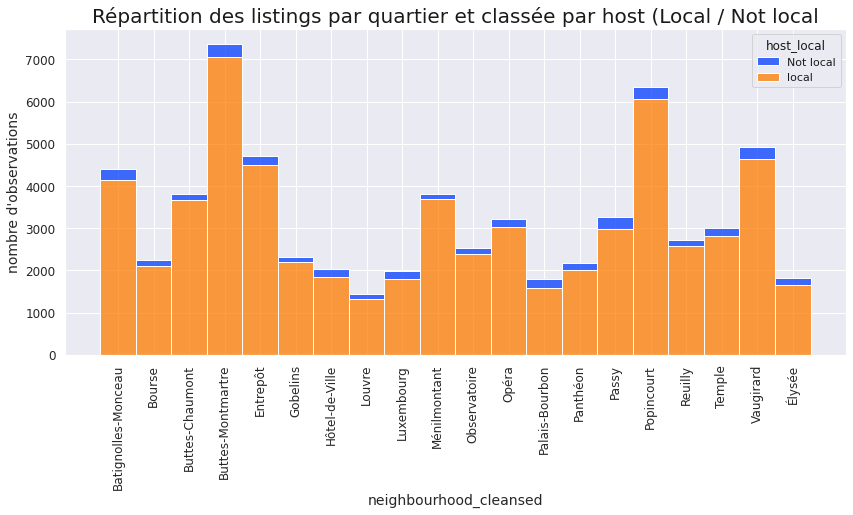

In [ ]:
%%time
f = plt.figure(figsize=(14,6))
ax = f.add_subplot(1,1,1)
sns.histplot(data=df_listings_clean, ax=ax, stat="count", multiple="stack",
             x="neighbourhood_cleansed", kde=False,
             palette="bright", hue=aux,
             element="bars", legend=True)
ax.set_title("Répartition des listings par quartier et classée par host (Local / Not local",fontsize=20)
ax.set_xlabel("neighbourhood_cleansed")
ax.set_ylabel("nombre d'observations")
plt.xticks(rotation=90)

CPU times: user 160 ms, sys: 5.94 ms, total: 166 ms
Wall time: 170 ms


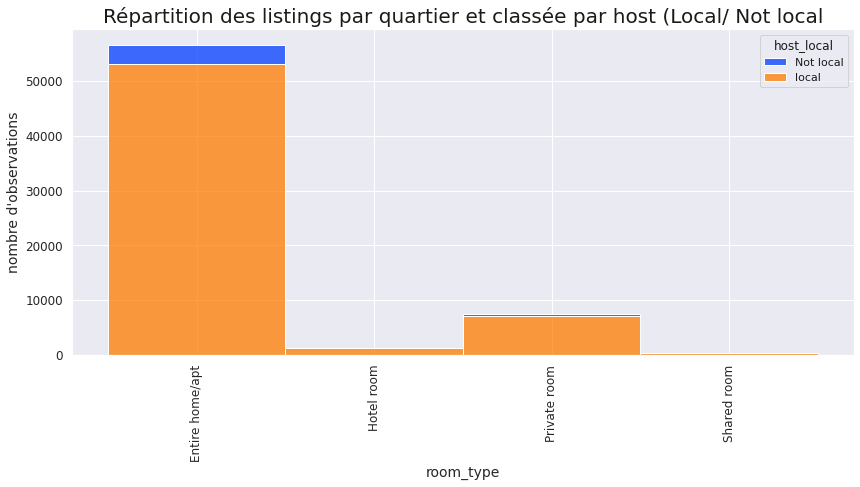

In [ ]:
%%time
f = plt.figure(figsize=(14,6))
ax = f.add_subplot(1,1,1)
sns.histplot(data=df_listings_clean, ax=ax, stat="count", multiple="stack",
             x="room_type", kde=False,
             palette="bright", hue=aux,
             element="bars", legend=True)
ax.set_title("Répartition des listings par quartier et classée par host (Local/ Not local",fontsize=20)
ax.set_xlabel("room_type")
ax.set_ylabel("nombre d'observations")
plt.xticks(rotation=90)

- Après avoir créé **host_local** qui contient 1 si l'hôte est résident en france et 0 sinon, je supprime la colonne textuelle **host_location** car elle contient les mêmes informations que la nouvelle

In [ ]:
df_listings_clean.drop(['host_location'], axis=1, inplace = True)
df_listings_clean.columns

Index(['listing_id', 'name', 'description', 'host_since', 'host_is_superhost',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood_cleansed', 'latitude', 'longitude', 'property_type',
       'room_type', 'accommodates', 'bathrooms_text', 'bedrooms', 'beds',
       'amenities', 'price', 'minimum_nights', 'maximum_nights',
       'has_availability', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'number_of_reviews',
       'number_of_reviews_ltm', 'number_of_reviews_l30d', 'last_review',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'instant_bookable',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_coun

### **host_since**: peut être utilisé pour calculer l'expérience des hôtes en fonction de la durée depuis leur première inscription



In [ ]:
df_listings_clean.host_since.isna().sum()

0

In [ ]:
df_listings_clean.host_since.value_counts()

2019-09-02    769
2013-04-23    261
2015-05-21    261
2012-06-18    248
2013-07-22    231
             ... 
2020-10-24      1
2009-11-27      1
2010-02-24      1
2011-03-07      1
2010-02-23      1
Name: host_since, Length: 3816, dtype: int64

In [ ]:
df_listings_clean.host_since.isna().sum()

0

In [ ]:
host_since_year = []
for date in df_listings_clean.host_since:
    try:
      host_since_year.append((pd.to_datetime(date, format='%Y-%m-%d')).year)
    except ValueError:
      print("[Oops!] %s There was not a valid datetime value. 'Nan' will be used for this row..."%date)
df_listings_clean['host_since_year'] = host_since_year

In [ ]:
df_listings_clean.host_since_year.isna().sum()

28

In [ ]:
df_listings_clean.host_since_year.value_counts()

2015.0    12295
2014.0    11051
2016.0     8991
2013.0     8317
2019.0     6353
2012.0     4656
2017.0     4642
2018.0     4304
2020.0     3382
2011.0     1350
2010.0      427
2009.0      116
2008.0        5
Name: host_since_year, dtype: int64

In [ ]:
df_listings_clean.host_since_year.dtypes

dtype('float64')

In [ ]:
df_listings_clean = replace_missing_values(['host_since_year'], df_listings_clean)

Imputer la colonne host_since_year avec la valeure de la medianne


In [ ]:
df_listings_clean.host_since_year.isna().sum()

0

In [ ]:
df_listings_clean.host_since_year.value_counts()

2015.0    12323
2014.0    11051
2016.0     8991
2013.0     8317
2019.0     6353
2012.0     4656
2017.0     4642
2018.0     4304
2020.0     3382
2011.0     1350
2010.0      427
2009.0      116
2008.0        5
Name: host_since_year, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


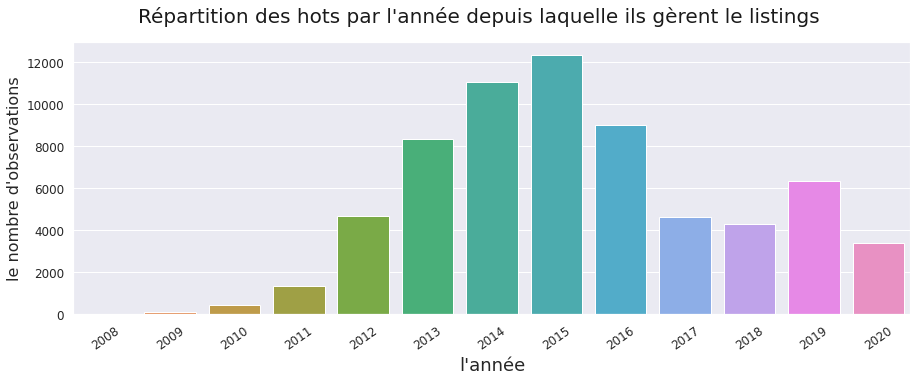

CPU times: user 323 ms, sys: 13.1 ms, total: 336 ms
Wall time: 332 ms


In [ ]:
%%time
aux = df_listings_clean.host_since_year.value_counts()
x = [int(i) for i in aux.index]
fig = plt.figure(figsize=(15,5))
g=sns.barplot(x, y=list(aux))
fig.suptitle('Répartition des hots par l\'année depuis laquelle ils gèrent le listings', fontsize=20)
plt.xlabel('l\'année', fontsize=18)
plt.ylabel('le nombre d\'observations', fontsize=16)
plt.xticks(rotation=35)
plt.show()

- sur la base de la colonne host_since la date à laquelle l'hôte se charge de la gestion des biens j'ai calculé le nombre d'années d'expérience de l'hôte 

In [ ]:
df_listings_clean['host_expeience'] = 2020 - df_listings_clean['host_since_year']
df_listings_clean.loc[:,["host_since_year", "host_expeience"]]

host_since_year  host_expeience
0               2008.0            12.0
1               2008.0            12.0
2               2009.0            11.0
3               2009.0            11.0
4               2008.0            12.0
...                ...             ...
65912           2020.0             0.0
65913           2018.0             2.0
65914           2018.0             2.0
65915           2016.0             4.0
65916           2014.0             6.0

[65917 rows x 2 columns]

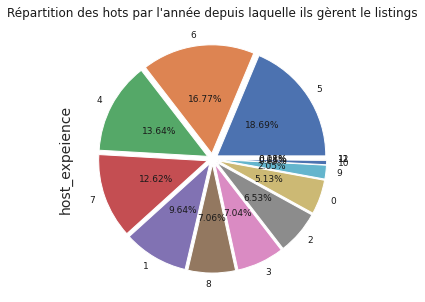

In [ ]:
label = [int(x) for x in df_listings_clean.host_expeience.value_counts().index]
df_listings_clean['host_expeience'].value_counts().plot(kind='pie', autopct='%.2f%%', 
                                                   labels=label,
                                                   explode=[0.05]*13, pctdistance=0.5,
                                                   title='Répartition des hots par l\'année depuis laquelle ils gèrent le listings',
                                                   figsize=(15,5),
                                                   fontsize=9)

In [ ]:
df_listings_clean = replace_missing_values(['host_expeience'], df_listings_clean)

Imputer la colonne host_expeience avec la valeure de la medianne


In [ ]:
df_listings_clean.host_expeience.isna().sum()

0

- Après avoir créé la colonne **host_since_year** qui contient l'année où l'hôte commence à gérer le marchandise a partir de la colonne **host_since**, j'ai créé le nombre d'années d'expérience **`host_expeience`** sur la base de cette information et comme cette colonne contient les mêmes informations que host_since et host_since_year, je vais la conserver et supprimer les autres

In [ ]:
df_listings_clean.drop(['host_since_year', 'host_since'], axis=1, inplace=True)
df_listings_clean.columns

Index(['listing_id', 'name', 'description', 'host_is_superhost',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood_cleansed', 'latitude', 'longitude', 'property_type',
       'room_type', 'accommodates', 'bathrooms_text', 'bedrooms', 'beds',
       'amenities', 'price', 'minimum_nights', 'maximum_nights',
       'has_availability', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'number_of_reviews',
       'number_of_reviews_ltm', 'number_of_reviews_l30d', 'last_review',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'instant_bookable',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_room

## **amenities**: les caractéristiques uniques (plus de 100), nous nous concentrerons sur le nombre total de ces équipements pour la partie analyse.


In [ ]:
df_listings_clean.amenities.iloc[0]

'["Dryer", "Host greets you", "Hot water", "Hangers", "Iron", "Wifi", "Dedicated workspace", "Heating", "TV", "Washer", "Essentials", "Kitchen"]'

In [ ]:
df_listings_clean['amenities_count'] = [len(ameniti) for ameniti in df_listings_clean.amenities]
df_listings_clean.amenities_count.value_counts().sort_index()

2       225
6         3
8        11
10        1
11        4
       ... 
995       1
997       1
1089      1
1092      1
1155      1
Name: amenities_count, Length: 816, dtype: int64

In [ ]:
df_listings_clean.amenities_count.isna().sum()

0

In [ ]:
df_listings_clean = replace_missing_values(['amenities_count'], df_listings_clean)

Imputer la colonne amenities_count avec la valeure de la medianne


In [ ]:
df_listings_clean.amenities_count.value_counts().sort_index()

2.0       225
6.0         3
8.0        11
10.0        1
11.0        4
         ... 
995.0       1
997.0       1
1089.0      1
1092.0      1
1155.0      1
Name: amenities_count, Length: 816, dtype: int64

In [ ]:
df_listings_clean.amenities_count.isna().sum()

0

In [ ]:
df_listings_clean.amenities_count.describe()

count    65917.000000
mean       238.265319
std        137.040111
min          2.000000
25%        128.000000
50%        213.000000
75%        326.000000
max       1155.000000
Name: amenities_count, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


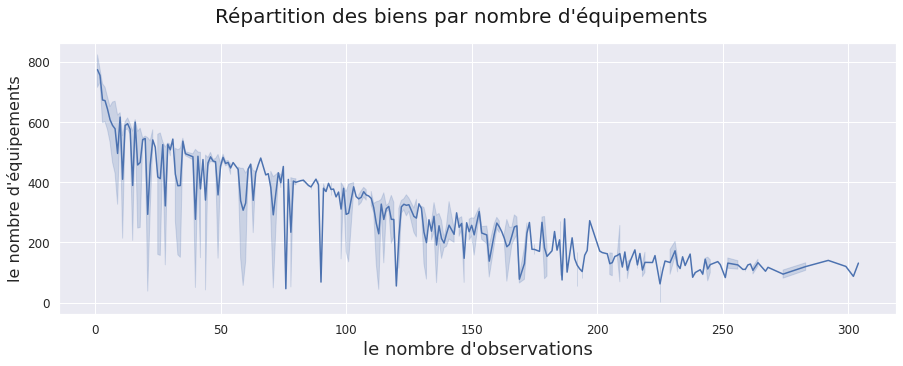

CPU times: user 3.91 s, sys: 14.9 ms, total: 3.92 s
Wall time: 3.94 s


In [ ]:
%%time
aux = df_listings_clean.amenities_count.value_counts().sort_index()
fig = plt.figure(figsize=(15,5))
g=sns.lineplot(list(aux), aux.index)
fig.suptitle('Répartition des biens par nombre d\'équipements ', fontsize=20)
plt.xlabel('le nombre d\'observations', fontsize=18)
plt.ylabel('le nombre d\'équipements', fontsize=16)
plt.xticks(rotation=0)
plt.show()

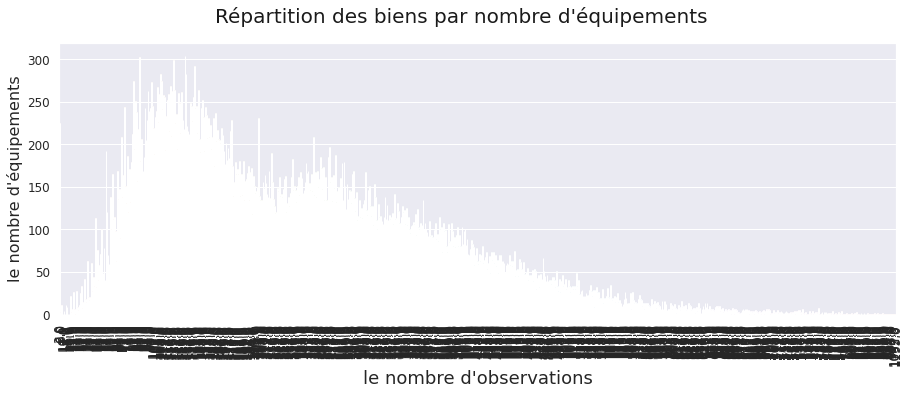

CPU times: user 19.6 s, sys: 1.33 s, total: 20.9 s
Wall time: 21 s


In [ ]:
%%time
fig = plt.figure(figsize=(15,5))
g = sns.countplot(x='amenities_count', data=df_listings_clean);
fig.suptitle('Répartition des biens par nombre d\'équipements ', fontsize=20)
plt.xlabel('le nombre d\'observations', fontsize=18)
plt.ylabel('le nombre d\'équipements', fontsize=16)
plt.xticks(rotation=90)
plt.show()

##Créer des features à partir de **amenities**


In [ ]:
df_listings_clean.amenities.head()

0    ["Dryer", "Host greets you", "Hot water", "Han...
1    ["Children\u2019s books and toys", "Paid parki...
2    ["Dryer", "Host greets you", "Hangers", "Iron"...
3    ["Oven", "Fire extinguisher", "Host greets you...
4    ["Oven", "Paid parking off premises", "Hangers...
Name: amenities, dtype: object

In [ ]:
# supprimer les accolades
df_listings_clean["amenities"] = df_listings_clean["amenities"].apply(lambda x : x[1:-1])
df_listings_clean.amenities.head()

0    "Dryer", "Host greets you", "Hot water", "Hang...
1    "Children\u2019s books and toys", "Paid parkin...
2    "Dryer", "Host greets you", "Hangers", "Iron",...
3    "Oven", "Fire extinguisher", "Host greets you"...
4    "Oven", "Paid parking off premises", "Hangers"...
Name: amenities, dtype: object

In [ ]:
amenities = df_listings_clean.amenities

In [ ]:
import re

In [ ]:
# créer un dictionnaire de termes
amenities_idx ={}
idx = 0
corpus = []
for i in range(len(amenities)):
    items = amenities[i]
    items_lower = items.lower()
    tokens = items_lower.split(',')
    tokens = [(re.sub('[^a-zA-Z0-9 \n\.]', '', token)).strip() for token in tokens]

    corpus.append(tokens)
    for token in tokens:
        if token not in amenities_idx:
            amenities_idx[token] = idx
            idx += 1
amenities_idx

{'': 98,
 '100 hdtv with netflix': 339,
 '2 fours microonde et chaleur tournante stainless steel oven': 86,
 '2 plaques u00e9lectriques electric stove': 538,
 '2 ru00e9frigu00e9rateur encastru00e9s refrigerator': 337,
 '23 hdtv with premium cable': 117,
 '23 tv with netflix': 443,
 '24 hdtv': 362,
 '24hour fitness center': 506,
 '25 years old': 535,
 '32 hdtv': 214,
 '32 hdtv with amazon prime video': 399,
 '32 hdtv with netflix': 368,
 '32 tv': 426,
 '35 hdtv with standard cable': 477,
 '40 hdtv': 323,
 '40 hdtv with netflix': 283,
 '40 hdtv with standard cable': 484,
 '42 hdtv with netflix': 135,
 '43 hdtv with netflix': 316,
 '45 hdtv with premium cable': 503,
 '510 years old': 536,
 '55 hdtv': 504,
 '55 hdtv with netflix': 168,
 '55 hdtv with premium cable': 297,
 '65 hdtv with netflix': 462,
 '65 hdtv with premium cable': 295,
 '7 plantes cien shampoo': 472,
 'a la reception refrigerator': 456,
 'a la ru00e9ception refrigerator': 451,
 'a partager refrigerator': 474,
 'aesop condi

In [ ]:
corpus[:2]

[['dryer',
  'host greets you',
  'hot water',
  'hangers',
  'iron',
  'wifi',
  'dedicated workspace',
  'heating',
  'tv',
  'washer',
  'essentials',
  'kitchen'],
 ['childrenu2019s books and toys',
  'paid parking off premises',
  'smart lock',
  'hangers',
  'iron',
  'wifi',
  'hair dryer',
  'dedicated workspace',
  'luggage dropoff allowed',
  'hot water',
  'washer',
  'smoke alarm',
  'kitchen']]

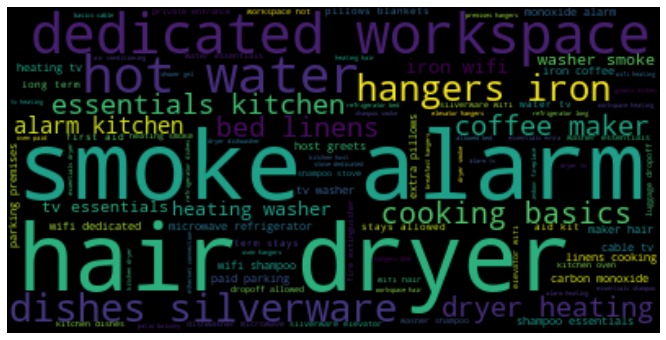

In [ ]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ' '.join([item for sublist in corpus for item in sublist])
# Generate a word cloud
wordcloud=WordCloud(contour_width=3,
                    contour_color='steelblue',
                    background_color="black").generate(long_string)
# Display the generated image:
plt.figure(figsize = (18,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
print("Nombre total de termes dans le corpus : ", len(amenities_idx))
print("Nombre total de documents dans le corpus : ", len(corpus))

Nombre total de termes dans le corpus :  549
Nombre total de documents dans le corpus :  65917


In [ ]:
# Obtenir le nombre d'articles et de tokens 
M = len(amenities)
N = len(amenities_idx)

# Initialiser la matrice avec des zéros
A = np.zeros((M, N))
A.shape

(65917, 549)

- Nous pouvons alors définir une fonction d'encodage qui mettra 1 dans l'index correspondant dans la matrice. Et enfin, nous créerons la matrice document - terme en appliquant cette fonction d'encodage à tous les documents du corpus

In [ ]:
# Définir la fonction amenity_encoder
def amenity_encoder(tokens):
    x = np.zeros(N)
    for token in tokens:
        # Obtenir l'indice pour chaque équipement
        idx = amenities_idx[token]
        # Mettre 1 aux indices correspondants
        x[idx] = 1
    return x

In [ ]:
# Créatioon de la matrice document-term 
i = 0
for tokens in corpus:
    A[i, :] = amenity_encoder(tokens)
    i = i + 1

In [ ]:
A

array([[1., 1., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 1., ..., 1., 1., 1.]])

In [ ]:
amenities_features = pd.DataFrame(A, columns=list(amenities_idx.keys()))
amenities_features.head()

dryer  host greets you  hot water  hangers  iron  wifi  \
0    1.0              1.0        1.0      1.0   1.0   1.0   
1    0.0              0.0        1.0      1.0   1.0   1.0   
2    1.0              1.0        0.0      1.0   1.0   1.0   
3    0.0              1.0        1.0      1.0   0.0   0.0   
4    0.0              1.0        1.0      1.0   1.0   1.0   

   dedicated workspace  heating   tv  washer  essentials  kitchen  \
0                  1.0      1.0  1.0     1.0         1.0      1.0   
1                  1.0      0.0  0.0     1.0         0.0      1.0   
2                  0.0      1.0  1.0     1.0         1.0      1.0   
3                  1.0      1.0  0.0     1.0         1.0      1.0   
4                  1.0      1.0  1.0     1.0         1.0      1.0   

   childrenu2019s books and toys  paid parking off premises  smart lock  \
0                            0.0                        0.0         0.0   
1                            1.0                        1.0         1.0   
2                            0.0                        0.0         0.0   
3                            0.0                        0.0         0.0   
4                            0.0                        1.0         0.0   

   hair dryer  luggage dropoff allowed  smoke alarm  cable tv  shampoo  oven  \
0         0.0                      0.0          0.0       0.0      0.0   0.0   
1         1.0                      1.0          1.0       0.0      0.0   0.0   
2         1.0                      0.0          0.0       1.0      1.0   0.0   
3         1.0                      0.0          1.0       0.0      1.0   1.0   
4         1.0                      0.0          1.0       1.0      1.0   1.0   

   fire extinguisher  stove  refrigerator  dishes and silverware  \
0                0.0    0.0           0.0                    0.0   
1                0.0    0.0           0.0                    0.0   
2                0.0    0.0           0.0                    0.0   
3                1.0    1.0           1.0                    1.0   
4                0.0    1.0           1.0                    1.0   

   long term stays allowed  bed linens  extra pillows and blankets  \
0                      0.0         0.0                         0.0   
1                      0.0         0.0                         0.0   
2                      0.0         0.0                         0.0   
3                      1.0         1.0                         1.0   
4                      0.0         1.0                         1.0   

   cooking basics  coffee maker  microwave  carbon monoxide alarm  elevator  \
0             0.0           0.0        0.0                    0.0       0.0   
1             0.0           0.0        0.0                    0.0       0.0   
2             0.0           0.0        0.0                    0.0       0.0   
3             1.0           0.0        0.0                    0.0       0.0   
4             1.0           1.0        1.0                    1.0       0.0   

   first aid kit  shower gel  building staff  indoor fireplace  dishwasher  \
0            0.0         0.0             0.0               0.0         0.0   
1            0.0         0.0             0.0               0.0         0.0   
2            0.0         0.0             0.0               0.0         0.0   
3            0.0         0.0             0.0               0.0         0.0   
4            0.0         0.0             0.0               0.0         0.0   

   breakfast  single level home  patio or balcony  lockbox  \
0        0.0                0.0               0.0      0.0   
1        0.0                0.0               0.0      0.0   
2        0.0                0.0               0.0      0.0   
3        0.0                0.0               0.0      0.0   
4        0.0                0.0               0.0      0.0   

   free street parking  outlet covers  roomdarkening shades  \
0                  0.0            0.0                   0.0   
1               

In [ ]:
amenities_features.shape

(65917, 549)

In [ ]:
import re
def clean_column(text):
    # remplacer les espace par underscore "_"
    text = re.sub(r'[\s+]', '_', text)
    # supprimer les quotes ""
    text = re.sub(r'[\"]', '', text)
    
    return text
amenities_features.columns = ["amenities_" + clean_column(item) for item in list(amenities_features.columns)]

In [ ]:
amenities_features.head()

amenities_dryer  amenities_host_greets_you  amenities_hot_water  \
0              1.0                        1.0                  1.0   
1              0.0                        0.0                  1.0   
2              1.0                        1.0                  0.0   
3              0.0                        1.0                  1.0   
4              0.0                        1.0                  1.0   

   amenities_hangers  amenities_iron  amenities_wifi  \
0                1.0             1.0             1.0   
1                1.0             1.0             1.0   
2                1.0             1.0             1.0   
3                1.0             0.0             0.0   
4                1.0             1.0             1.0   

   amenities_dedicated_workspace  amenities_heating  amenities_tv  \
0                            1.0                1.0           1.0   
1                            1.0                0.0           0.0   
2                            0.0                1.0           1.0   
3                            1.0                1.0           0.0   
4                            1.0                1.0           1.0   

   amenities_washer  amenities_essentials  amenities_kitchen  \
0               1.0                   1.0                1.0   
1               1.0                   0.0                1.0   
2               1.0                   1.0                1.0   
3               1.0                   1.0                1.0   
4               1.0                   1.0                1.0   

   amenities_childrenu2019s_books_and_toys  \
0                                      0.0   
1                                      1.0   
2                                      0.0   
3                                      0.0   
4                                      0.0   

   amenities_paid_parking_off_premises  amenities_smart_lock  \
0                                  0.0                   0.0   
1                                  1.0                   1.0   
2                                  0.0                   0.0   
3                                  0.0                   0.0   
4                                  1.0                   0.0   

   amenities_hair_dryer  amenities_luggage_dropoff_allowed  \
0                   0.0                                0.0   
1                   1.0                                1.0   
2                   1.0                                0.0   
3                   1.0                                0.0   
4                   1.0                                0.0   

   amenities_smoke_alarm  amenities_cable_tv  amenities_shampoo  \
0                    0.0                 0.0                0.0   
1                    1.0                 0.0                0.0   
2                    0.0                 1.0                1.0   
3                    1.0                 0.0                1.0   
4                    1.0                 1.0                1.0   

   amenities_oven  amenities_fire_extinguisher  amenities_stove  \
0             0.0                          0.0              0.0   
1             0.0                          0.0              0.0   
2             0.0                          0.0              0.0   
3             1.0                          1.0              1.0   
4             1.0                          0.0              1.0   

   amenities_refrigerator  amenities_dishes_and_silverware  \
0                     0.0                              0.0   
1                     0.0                              0.0   
2                     0.0                              0.0   
3                     1.0                              1.0   
4                     1.0                              1.0   

   amenities_long_term_stays_allowed  amenities_bed_linens  \
0                                0.0                   0.0   
1                                0.0                   0.0   
2                                0.0         

##Créer des features à partir de host_verifications


In [ ]:
df_listings_clean.host_verifications[:10]

0    ['email', 'phone', 'reviews', 'jumio', 'govern...
1            ['email', 'phone', 'facebook', 'reviews']
2    ['email', 'phone', 'reviews', 'offline_governm...
3    ['email', 'phone', 'facebook', 'google', 'revi...
4    ['email', 'phone', 'reviews', 'jumio', 'offlin...
5    ['email', 'phone', 'reviews', 'jumio', 'offlin...
6    ['email', 'phone', 'reviews', 'jumio', 'offlin...
7    ['email', 'phone', 'reviews', 'jumio', 'offlin...
8    ['email', 'phone', 'manual_online', 'facebook'...
9    ['email', 'phone', 'manual_online', 'facebook'...
Name: host_verifications, dtype: object

In [ ]:
import re
re.findall(r'\w+', df_listings_clean.host_verifications[1])

['email', 'phone', 'facebook', 'reviews']

In [ ]:
## Nettoyer les liste de mots en ne gardant que les caractères alphabétiques "\w"
df_listings_clean.loc[:, 'host_verifications'] = df_listings_clean.host_verifications.apply(lambda x: re.findall(r'\w+', x))

Aprés je vais créer un dictionnaire des mots de la colonnes 'host_verifications'

In [ ]:
verifications = df_listings_clean.host_verifications
verifications

0            [email, phone, reviews, jumio, government_id]
1                        [email, phone, facebook, reviews]
2        [email, phone, reviews, offline_government_id,...
3        [email, phone, facebook, google, reviews, jumi...
4        [email, phone, reviews, jumio, offline_governm...
                               ...                        
65912    [email, phone, offline_government_id, selfie, ...
65913                                       [email, phone]
65914    [email, phone, offline_government_id, selfie, ...
65915    [phone, reviews, jumio, selfie, government_id,...
65916    [email, phone, facebook, google, reviews, jumi...
Name: host_verifications, Length: 65917, dtype: object

In [ ]:
verification_idx = {}
idx = 0
corpus = []
for i in range(len(verifications)):
    items = verifications[i]
    corpus.append(items)
    for item in items:
        if item not in verification_idx:
            verification_idx[item] = idx
            idx += 1

In [ ]:
verification_idx

{'None': 15,
 'email': 0,
 'facebook': 5,
 'google': 9,
 'government_id': 4,
 'identity_manual': 8,
 'jumio': 3,
 'kba': 13,
 'manual_offline': 11,
 'manual_online': 10,
 'offline_government_id': 6,
 'phone': 1,
 'reviews': 2,
 'selfie': 7,
 'sent_id': 14,
 'sesame': 18,
 'sesame_offline': 19,
 'weibo': 17,
 'work_email': 12,
 'zhima_selfie': 16}

In [ ]:
corpus[:3]

[['email', 'phone', 'reviews', 'jumio', 'government_id'],
 ['email', 'phone', 'facebook', 'reviews'],
 ['email',
  'phone',
  'reviews',
  'offline_government_id',
  'selfie',
  'government_id',
  'identity_manual']]

In [ ]:
print("Nombre total de termes dans le corpus : ", len(verification_idx))
print("Nombre total de documents dans le corpus : ", len(corpus))

Nombre total de termes dans le corpus :  20
Nombre total de documents dans le corpus :  65917


Ensuite, je crée une représentation bag-of-words binaire de la liste des mots pour la vérification de l'hôte de chaque liste airbnb (ligne). La matrice est convertie en une Dataframe pandas en utilisant le dictionnaire verification_idx des termes comme colonnes de la Dataframe.

In [ ]:
# Le nombre d'items et tokens 
M = len(verifications)
N = len(verification_idx)

# Initialiser la matrix avec des zeros
B = np.zeros((M, N))
B.shape

(65917, 20)

In [ ]:
# Définir la fonction verification_encoder
def verification_encoder(tokens):
    x = np.zeros(N)
    for token in tokens:
        # Obtenir l'index pour chaque vérification
        idx = verification_idx[token]
        # Mettre 1 aux indices correspondants
        x[idx] = 1
    return x

In [ ]:
# Création d'une matrice document-term
i = 0
for tokens in corpus:
    B[i, :] = verification_encoder(tokens)
    i = i + 1

In [ ]:
B

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [1., 1., 0., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.]])

In [ ]:
verification_features = pd.DataFrame(B, columns=list(verification_idx.keys()))
verification_features.columns = verification_features.add_prefix('host_verification_by_').columns

In [ ]:
verification_features.head()

host_verification_by_email  host_verification_by_phone  \
0                         1.0                         1.0   
1                         1.0                         1.0   
2                         1.0                         1.0   
3                         1.0                         1.0   
4                         1.0                         1.0   

   host_verification_by_reviews  host_verification_by_jumio  \
0                           1.0                         1.0   
1                           1.0                         0.0   
2                           1.0                         0.0   
3                           1.0                         1.0   
4                           1.0                         1.0   

   host_verification_by_government_id  host_verification_by_facebook  \
0                                 1.0                            0.0   
1                                 0.0                            1.0   
2                                 1.0                            0.0   
3                                 1.0                            1.0   
4                                 1.0                            0.0   

   host_verification_by_offline_government_id  host_verification_by_selfie  \
0                                         0.0                          0.0   
1                                         0.0                          0.0   
2                                         1.0                          1.0   
3                                         0.0                          0.0   
4                                         1.0                          1.0   

   host_verification_by_identity_manual  host_verification_by_google  \
0                                   0.0                          0.0   
1                                   0.0                          0.0   
2                                   1.0                          0.0   
3                                   0.0                          1.0   
4                                   1.0                          0.0   

   host_verification_by_manual_online  host_verification_by_manual_offline  \
0                                 0.0                                  0.0   
1                                 0.0                                  0.0   
2                                 0.0                                  0.0   
3                                 0.0                                  0.0   
4                                 0.0                                  0.0   

   host_verification_by_work_email  host_verification_by_kba  \
0                              0.0                       0.0   
1                              0.0                       0.0   
2                              0.0                       0.0   
3                              0.0                       0.0   
4                              0.0                       0.0   

   host_verification_by_sent_id  host_verification_by_None  \
0                           0.0                        0.0   
1                           0.0                        0.0   
2                           0.0                        0.0   
3                           0.0                        0.0   
4                           0.0                        0.0   

   host_verification_by_zhima_selfie  host_verification_by_weibo  \
0                                0.0                         0.0   
1                                0.0                         0.0   
2                                0.0                         0.0   
3                                0.0                         0.0   
4                                0.0                         0.0   

   host_verification_by_sesame  host_verification_by_sesame_offline  
0                          0.0                                  0.0  
1                          0.0                                  0.0  
2                          0.0                                  0.0  
3     

In [ ]:
verification_features.shape

(65917, 20)

##Créer des Feature à partir de colonnes de texte


In [ ]:
df_listings_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65917 entries, 0 to 65916
Data columns (total 47 columns):
 #   Column                                        Non-Null Count  Dtype   
---  ------                                        --------------  -----   
 0   listing_id                                    65917 non-null  int64   
 1   name                                          65917 non-null  object  
 2   description                                   65917 non-null  object  
 3   host_is_superhost                             65917 non-null  object  
 4   host_listings_count                           65917 non-null  float64 
 5   host_total_listings_count                     65917 non-null  float64 
 6   host_verifications                            65917 non-null  object  
 7   host_has_profile_pic                          65917 non-null  object  
 8   host_identity_verified                        65917 non-null  object  
 9   neighbourhood_cleansed                        6591

In [ ]:
df_listings_clean.description

0        100 m2 loft (1100 sq feet) with high ceiling, ...
1        <b>The space</b><br />I bedroom appartment in ...
2        Stylish & Classic One bedroom apartment for up...
3        Cozy, well-appointed and graciously designed s...
4        VERY CONVENIENT, WITH THE BEST LOCATION !<br /...
                               ...                        
65912    Notre suite junior est faite pour accueillir l...
65913    Beautiful apartment in the heart of old St Mic...
65914    Beautiful apartment in the heart of old St Mic...
65915    Je loue une partie de mon salon qui vous sera ...
65916    Enjoy a truly Parisian way of life experience ...
Name: description, Length: 65917, dtype: object

In [ ]:
import nltk
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
import re
import pandas as pd
import numpy as np
import nltk
import string
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn

# définir un certain nombre de termes courants
custom_stopwords = ['bedroom', 'bathroom', 'apartment']

# supprimer les trait d'union "-"
def remove_hypens(book_text):
    return re.sub(r'(\w+)-(\w+)-?(\w)?', r'\1 \2 \3', book_text)

# tokenize text
def tokenize_text(book_text):
    TOKEN_PATTERN = r'\s+'
    regex_wt = nltk.RegexpTokenizer(pattern=TOKEN_PATTERN, gaps=True)
    word_tokens = regex_wt.tokenize(book_text)
    return word_tokens

def remove_characters_after_tokenization(tokens):
    pattern = re.compile('[{}]'.format(re.escape(string.punctuation))) 
    filtered_tokens = filter(None, [pattern.sub('', token) for token in tokens]) 
    return filtered_tokens

def convert_to_lowercase(tokens):
    return [token.lower() for token in tokens if token.isalpha()]

def remove_stopwords(tokens, custom_stopwords):
    stopword_list = nltk.corpus.stopwords.words('english') + nltk.corpus.stopwords.words('french')
    stopword_list += custom_stopwords
    filtered_tokens = [token for token in tokens if token not in stopword_list]
    return filtered_tokens

def get_lemma(tokens):
    lemmas = []
    for word in tokens:
        lemma = wn.morphy(word)
        if lemma is None:
            lemmas.append(word)
        else:
            lemmas.append(lemma)
    return lemmas

def remove_short_tokens(tokens):
    return [token for token in tokens if len(token) > 3]

def keep_only_words_in_wordnet(tokens):
    return [token for token in tokens if wn.synsets(token)]

def apply_lemmatize(tokens, wnl=WordNetLemmatizer()):
    return [wnl.lemmatize(token) for token in tokens]

# chaque ligne de texte est considérée comme un book
# Cette fonction permet d'obtenir une liste de books

def nlp_pipeline(book_texts):
    clean_books = []
    for book in book_texts:
        book = remove_hypens(book)
        book_i = tokenize_text(book)
        book_i = remove_characters_after_tokenization(book_i)
        book_i = convert_to_lowercase(book_i)
        book_i = remove_stopwords(book_i, custom_stopwords)
        book_i = get_lemma(book_i)
        book_i = remove_short_tokens(book_i)
        book_i = keep_only_words_in_wordnet(book_i)
        book_i = apply_lemmatize(book_i)
        clean_books.append(book_i)
    return clean_books

In [ ]:
# utiliser la colonne des descriptions
descriptions = list(df_listings_clean.description)

# passer cette liste de descriptions par mon pipeline nlp
clean_descriptions = nlp_pipeline(descriptions)

In [ ]:
clean_descriptions[0]

['loft',
 'foot',
 'high',
 'ceiling',
 'open',
 'modern',
 'kitchen',
 'cable',
 'wifi',
 'sleeping',
 'space',
 'people',
 'area',
 'minute',
 'martin',
 'canal',
 'area',
 'district',
 'service',
 'shop',
 'desire',
 'walking',
 'distance',
 'many',
 'restaurant',
 'club',
 'well',
 'please',
 'suggest',
 'best',
 'address',
 'give',
 'direction',
 'enjoyable',
 'journey',
 'separate',
 'mezzanine',
 'second',
 'suite',
 'main',
 'welcome',
 'beautiful']

In [ ]:
# rejoindre les tokens pour former des chaînes de caractères qui serviront à 
# vectoriser aprés
clean_descriptions_text = [' '.join(item) for item in clean_descriptions]
clean_descriptions_text[:10]

['loft foot high ceiling open modern kitchen cable wifi sleeping space people area minute martin canal area district service shop desire walking distance many restaurant club well please suggest best address give direction enjoyable journey separate mezzanine second suite main welcome beautiful',
 'paris',
 'stylish classic guest newly renovate fully equip kitchen chef delight trendy north location walk dame minute block bretagne market street free river free river cruise booking mention offer classically furnish welcome expose ancient ceiling beam hardwood floor stylish decor mixing modern design gold gild mirror welcome respite locate temple walk heart paris minute short walk hotel river seine central island dame cathedral heart enjoy local bretagne block away authentic gourmet shop bakery cheese shop',
 'cozy well appoint graciously design studio aesthetic heart paris famous isle louis stone throw latin dame small well appoint studio heart paris famous isle four night minimum lookin

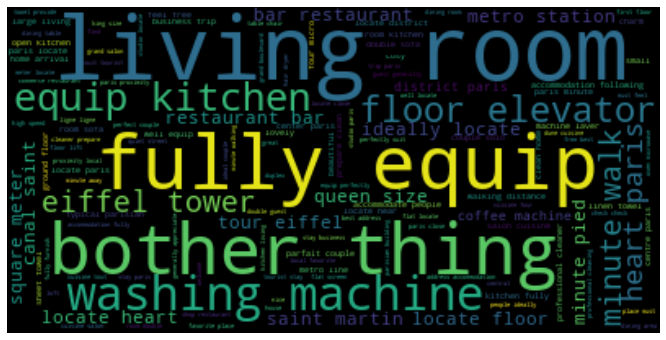

In [ ]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ' '.join([item for item in clean_descriptions_text])
# Generate a word cloud
wordcloud=WordCloud(contour_width=3,
                    contour_color='steelblue',
                    background_color="black").generate(long_string)
# Display the generated image:
plt.figure(figsize = (18,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

- **Vectoriser le corpus**
Maintenant que nous avons le corpus nettoyé, nous pouvons utiliser TfidfVectorizer pour convertir le texte en format vectoriel. En raison des limites de la mémoire, j'ai choisi de conserver max_features à 2000.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
stopword_list = nltk.corpus.stopwords.words('english') + nltk.corpus.stopwords.words('french')

tfidf_vectorizer = TfidfVectorizer(min_df=10, max_df=0.95, max_features=2000,
                                   ngram_range=(1,1), stop_words=stopword_list)

tfidf_feature_matrix = tfidf_vectorizer.fit_transform(clean_descriptions_text)
tfidf_feature_matrix.shape

(65917, 2000)

In [ ]:
type(tfidf_feature_matrix)

scipy.sparse.csr.csr_matrix

In [ ]:
display(tfidf_vectorizer.get_feature_names()[:10])
display(tfidf_vectorizer.get_feature_names()[-10:])

['abbess',
 'able',
 'absence',
 'absolute',
 'absolutely',
 'accent',
 'accept',
 'access',
 'accessible',
 'accommodate']

['worth',
 'worthy',
 'write',
 'writer',
 'yard',
 'year',
 'yoga',
 'young',
 'zola',
 'zone']

In [ ]:
# créer un dataframe à partir de la matrice des features 
feature_matrix_df = pd.DataFrame(tfidf_feature_matrix.toarray(), 
                                 columns=tfidf_vectorizer.get_feature_names())

feature_matrix_df.head()

abbess  able  absence  absolute  absolutely  accent  accept  access  \
0     0.0   0.0      0.0       0.0         0.0     0.0     0.0     0.0   
1     0.0   0.0      0.0       0.0         0.0     0.0     0.0     0.0   
2     0.0   0.0      0.0       0.0         0.0     0.0     0.0     0.0   
3     0.0   0.0      0.0       0.0         0.0     0.0     0.0     0.0   
4     0.0   0.0      0.0       0.0         0.0     0.0     0.0     0.0   

   accessible  accommodate  accommodation  accord  across  active  activity  \
0         0.0          0.0            0.0     0.0     0.0     0.0       0.0   
1         0.0          0.0            0.0     0.0     0.0     0.0       0.0   
2         0.0          0.0            0.0     0.0     0.0     0.0       0.0   
3         0.0          0.0            0.0     0.0     0.0     0.0       0.0   
4         0.0          0.0            0.0     0.0     0.0     0.0       0.0   

   actually  adapt  addition  additional   address  adjacent  adjoin  admire  \
0       0.0    0.0       0.0         0.0  0.164682  0.000000     0.0     0.0   
1       0.0    0.0       0.0         0.0  0.000000  0.000000     0.0     0.0   
2       0.0    0.0       0.0         0.0  0.000000  0.000000     0.0     0.0   
3       0.0    0.0       0.0         0.0  0.000000  0.159374     0.0     0.0   
4       0.0    0.0       0.0         0.0  0.000000  0.000000     0.0     0.0   

   admirer  adorable  adorn  adult  advance  advantage  adventurer  advice  \
0      0.0       0.0    0.0    0.0      0.0        0.0         0.0     0.0   
1      0.0       0.0    0.0    0.0      0.0        0.0         0.0     0.0   
2      0.0       0.0    0.0    0.0      0.0        0.0         0.0     0.0   
3      0.0       0.0    0.0    0.0      0.0        0.0         0.0     0.0   
4      0.0       0.0    0.0    0.0      0.0        0.0         0.0     0.0   

   advise  aesthetic  affaire  affordable  afternoon  agency  agent  \
0     0.0   0.000000      0.0         0.0        0.0     0.0    0.0   
1     0.0   0.000000      0.0         0.0        0.0     0.0    0.0   
2     0.0   0.000000      0.0         0.0        0.0     0.0    0.0   
3     0.0   0.176084      0.0         0.0        0.0     0.0    0.0   
4     0.0   0.000000      0.0         0.0        0.0     0.0    0.0   

   agreement  airport  airy  alcove  alive  alley  allow  almost  alone  \
0        0.0      0.0   0.0     0.0    0.0    0.0    0.0     0.0    0.0   
1        0.0      0.0   0.0     0.0    0.0    0.0    0.0     0.0    0.0   
2        0.0      0.0   0.0     0.0    0.0    0.0    0.0     0.0    0.0   
3        0.0      0.0   0.0     0.0    0.0    0.0    0.0     0.0    0.0   
4        0.0      0.0   0.0     0.0    0.0    0.0    0.0     0.0    0.0   

      along  already  also  ...  watch  watching  water  wave  weather  \
0  0.000000      0.0   0.0  ...    0.0       0.0    0.0   0.0      0.0   
1  0.000000      0.0   0.0  ...    0.0       0.0    0.0   0.0      0.0   
2  0.000000      0.0   0.0  ...    0.0       0.0    0.0   0.0      0.0   
3  0.130488      0.0   0.0  ...    0.0       0.0    0.0   0.0      0.0   
4  0.000000      0.0   0.0  ...    0.0       0.0    0.0   0.0      0.0   

   website  wednesday  week  weekend  weekly   welcome      well  west  \
0      0.0        0.0   0.0      0.0     0.0  0.120403  0.110281   0.0   
1      0.0        0.0   0.0      0.0     0.0  0.000000  0.000000   0.0   
2      0.0        0.0   0.0      0.0     0.0  0.146541  0.000000   0.0   
3      0.0        0.0   0.0      0.0     0.0  0.000000  0.139384   0.0   
4      0.0        0.0   0.0      0.0     0.0  0.000000  0.000000   0.0   

   whatever  whip  white  whole  wide      wifi  willing  window  wine  \
0       0.0   0.0    0.0    0.0   0.0  0.107441      0.0     0.0   0.0   
1       0.0   0.0    0.0    0.0   0.0  0.000000      0.0     0.0   0.0   
2       0.0   0.0    0.0    0.0   0.0  0.000000      0.0     0.0   0.0   
3       0.0   0.0    0.0    0.0   0.0  0.000000      0.0     0.0   0.

In [ ]:
feature_matrix_df.shape

(65917, 2000)

##**Fusionner tous les dataframes**


In [ ]:
print("Amenities dataframe shape: ", amenities_features.shape)
print("Host Verifications dataframe shape: ", verification_features.shape)
print("Descriptions dataframe shape: ", feature_matrix_df.shape)

Amenities dataframe shape:  (65917, 549)
Host Verifications dataframe shape:  (65917, 20)
Descriptions dataframe shape:  (65917, 2000)


In [ ]:
merged_df = pd.concat([amenities_features, verification_features, 
                       feature_matrix_df], axis='columns')
merged_df.shape

(65917, 2569)

In [ ]:
# Saving the preprocessed data
merged_df.to_csv('/content/drive/MyDrive/ML-PROJECT/merged_df.csv')

## **calculated_host_listings_count**: valeur continue qui correspond aux nombres effectifs de listings pour les hôtes - mesure permettant de déterminer l'expérience des hôtes ou de distinguer les entreprises des individus

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


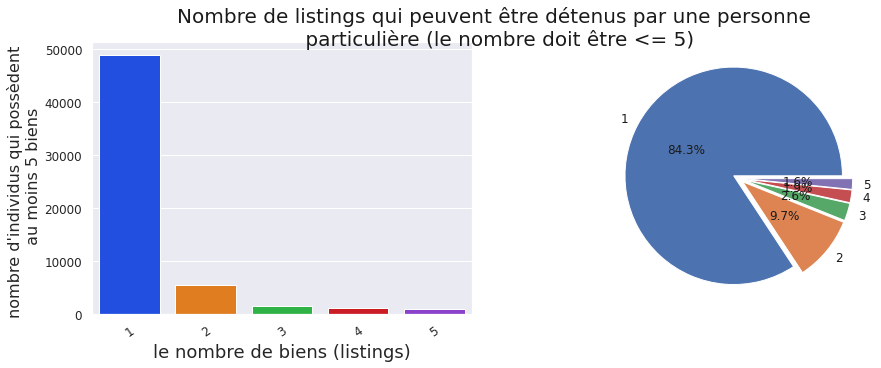

In [ ]:
max_number =5
aux = df_listings_clean.calculated_host_listings_count.value_counts().sort_index()[:max_number]
x = [str(i) for i in aux.index]
fig = plt.figure(figsize=(15,5))
plt.subplot(1,2,1);
g=sns.barplot(x, y=list(aux), palette="bright")
fig.suptitle('Nombre de listings qui peuvent être détenus par une personne \n particulière (le nombre doit être <= 5)', fontsize=20)
plt.xlabel('le nombre de biens (listings)', fontsize=18)
plt.ylabel('nombre d\'individus qui possèdent \n au moins 5 biens', fontsize=16)
plt.xticks(rotation=35)
plt.subplot(1,2,2);
plt.pie(x=list(aux), autopct="%.1f%%", explode=[0.05]*max_number, labels=x, pctdistance=0.5)
# plt.title("nombre d'individus qui possèdent \n moins de 7 biens",  wrap=True, fontsize=14);
del aux
plt.show()

In [ ]:
len(df_listings_clean.calculated_host_listings_count.value_counts().sort_index()[max_number:])

60

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


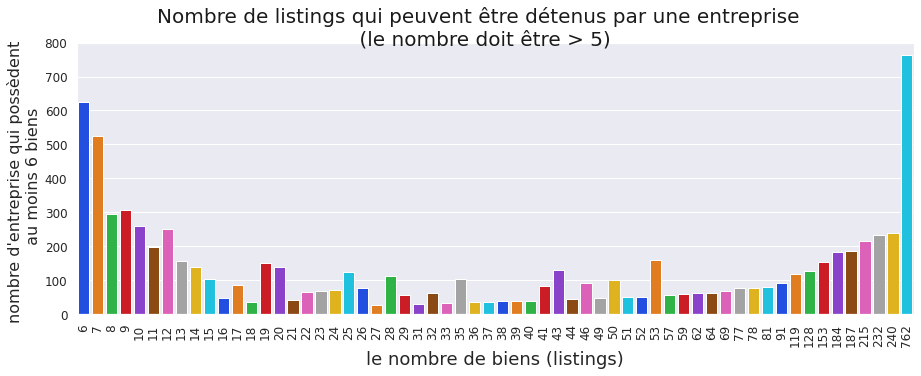

In [ ]:
max_number =5
aux = df_listings_clean.calculated_host_listings_count.value_counts().sort_index()[max_number:]
x = [str(i) for i in aux.index]
fig = plt.figure(figsize=(15,5))
# plt.subplot(1,2,1);
g=sns.barplot(x, y=list(aux), palette="bright")
fig.suptitle('Nombre de listings qui peuvent être détenus par une entreprise \n (le nombre doit être > 5)', fontsize=20)
plt.xlabel('le nombre de biens (listings)', fontsize=18)
plt.ylabel('nombre d\'entreprise qui possèdent \n au moins 6 biens', fontsize=16)
plt.xticks(rotation=90)
# plt.subplot(1,2,2);
# plt.pie(x=list(aux), autopct="%.1f%%", explode=[0.05]*60, labels=x, pctdistance=0.5)
# plt.title("nombre d'individus qui possèdent \n moins de 7 biens",  wrap=True, fontsize=14);
del aux
plt.show()

In [ ]:
df_listings_clean.columns

Index(['listing_id', 'name', 'description', 'host_is_superhost',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood_cleansed', 'latitude', 'longitude', 'property_type',
       'room_type', 'accommodates', 'bathrooms_text', 'bedrooms', 'beds',
       'amenities', 'price', 'minimum_nights', 'maximum_nights',
       'has_availability', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'number_of_reviews',
       'number_of_reviews_ltm', 'number_of_reviews_l30d', 'last_review',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'instant_bookable',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_room

##Visualisation du prix moyen du jour pour deux personnes

> Indented block




In [ ]:
df_listings.price.mean()

114.3518103069011

In [ ]:
df_listings_clean.neighbourhood_cleansed

0               Entrepôt
1           Observatoire
2                 Temple
3         Hôtel-de-Ville
4         Hôtel-de-Ville
              ...       
65912             Louvre
65913           Panthéon
65914           Panthéon
65915    Buttes-Chaumont
65916    Buttes-Chaumont
Name: neighbourhood_cleansed, Length: 65917, dtype: category
Categories (20, object): ['Batignolles-Monceau', 'Bourse', 'Buttes-Chaumont', 'Buttes-Montmartre', ...,
                          'Reuilly', 'Temple', 'Vaugirard', 'Élysée']

In [ ]:
aux = df_listings_clean[df_listings_clean.accommodates == 2 ].groupby(['neighbourhood_cleansed']).agg({'price': lambda x: x.mean(skipna=False)})
aux

price
neighbourhood_cleansed            
Batignolles-Monceau      81.086410
Bourse                   93.755996
Buttes-Chaumont          59.278502
Buttes-Montmartre        71.142428
Entrepôt                 74.771826
Gobelins                 66.272482
Hôtel-de-Ville          103.149946
Louvre                  126.978788
Luxembourg              114.827991
Ménilmontant             61.961012
Observatoire             70.475329
Opéra                    96.566351
Palais-Bourbon          125.619438
Panthéon                 88.526263
Passy                   108.651654
Popincourt               72.633314
Reuilly                  67.064263
Temple                  100.581805
Vaugirard                84.017736
Élysée                  146.272109

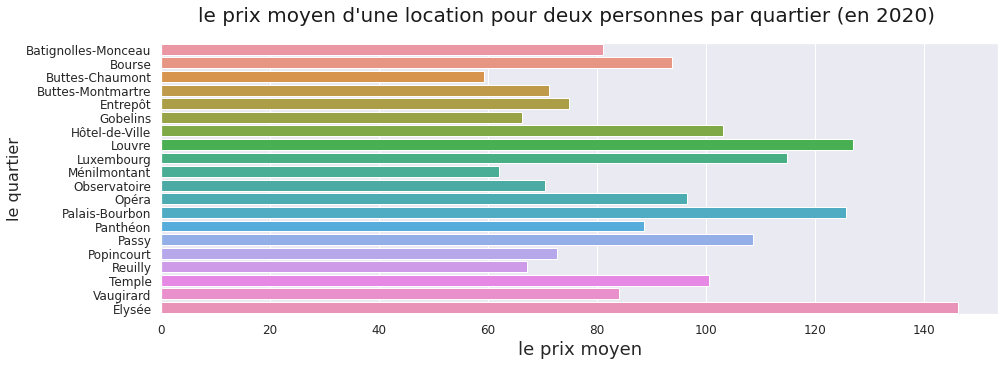

CPU times: user 392 ms, sys: 11 ms, total: 403 ms
Wall time: 409 ms


In [ ]:
%%time
y = [str(i) for i in aux.index]
fig = plt.figure(figsize=(15,5))
g=sns.barplot(x = list(aux.price), y=y, orient = 'h')
fig.suptitle('le prix moyen d\'une location pour deux personnes par quartier (en 2020)', fontsize=20)
plt.xlabel('le prix moyen', fontsize=18)
plt.ylabel('le quartier', fontsize=16)
plt.xticks(rotation=0)
plt.show()

- Le prix moyen pour une location de 2 personnes par quartier et par room type

In [ ]:
aux = df_listings_clean[df_listings_clean.accommodates == 2 ].groupby(['neighbourhood_cleansed','room_type']).agg({'price': lambda x: x.mean(skipna=False)})
aux

price
neighbourhood_cleansed room_type                  
Batignolles-Monceau    Entire home/apt   79.112332
                       Hotel room       161.785714
                       Private room      78.554098
                       Shared room       65.857143
Bourse                 Entire home/apt   91.481297
                       Hotel room       194.619048
                       Private room      92.325758
                       Shared room       67.500000
Buttes-Chaumont        Entire home/apt   61.515108
                       Hotel room       339.250000
                       Private room      47.524362
                       Shared room       37.538462
Buttes-Montmartre      Entire home/apt   73.002056
                       Hotel room       118.949153
                       Private room      54.164122
                       Shared room       39.375000
Entrepôt               Entire home/apt   75.323958
                       Hotel room       108.461538
                       Private room      69.548387
                       Shared room       44.888889
Gobelins               Entire home/apt   68.246231
                       Hotel room       166.545455
                       Private room      58.084175
                       Shared room       36.000000
Hôtel-de-Ville         Entire home/apt  101.498127
                       Hotel room       273.600000
                       Private room      93.500000
                       Shared room       61.000000
Louvre                 Entire home/apt  122.749027
                       Hotel room       187.651163
                       Private room     123.762376
                       Shared room       72.000000
Luxembourg             Entire home/apt  106.403873
                       Hotel room       193.191176
                       Private room     120.576389
                       Shared room       49.000000
Ménilmontant           Entire home/apt   65.298371
                       Hotel room       251.333333
                       Private room      44.650146
                       Shared room       39.000000
Observatoire           Entire home/apt   72.043617
                       Hotel room       126.074074
                       Private room      58.913580
                       Shared room       42.833333
Opéra                  Entire home/apt   88.805071
                       Hotel room       184.637168
                       Private room      96.863636
                       Shared room       46.800000
Palais-Bourbon         Entire home/apt   98.686080
                       Hotel room       252.854167
                       Private room     253.336634
                       Shared room       80.000000
Panthéon               Entire home/apt   84.657692
                       Hotel room       160.413043
                       Private room      88.859873
                       Shared room       39.714286
Passy                  Entire home/apt  100.373070
                       Hotel room       195.433962
                       Private room     135.609137
                       Shared room       57.200000
Popincourt             Entire home/apt   74.236743
                       Hotel room       175.628571
                       Private room      54.250585
                       Shared room       38.615385
Reuilly                Entire home/apt   69.111984
                       Hotel room       104.000000
                       Private room      56.548523
                       Shared room       42.666667
Temple                 Entire home/apt   95.087387
                       Hotel room       519.238095
                       Private room      85.280000
                       Shared room       47.000000
Vaugirard              Entire home/apt   80.104393
                       Hotel room       132.813559
                       Private room      98.885475
                       Shared room       44.687500
Élysée                 Entire home/apt  114.367793
                

In [ ]:
print (aux.unstack()['price'])

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text major ticklabel objects>)

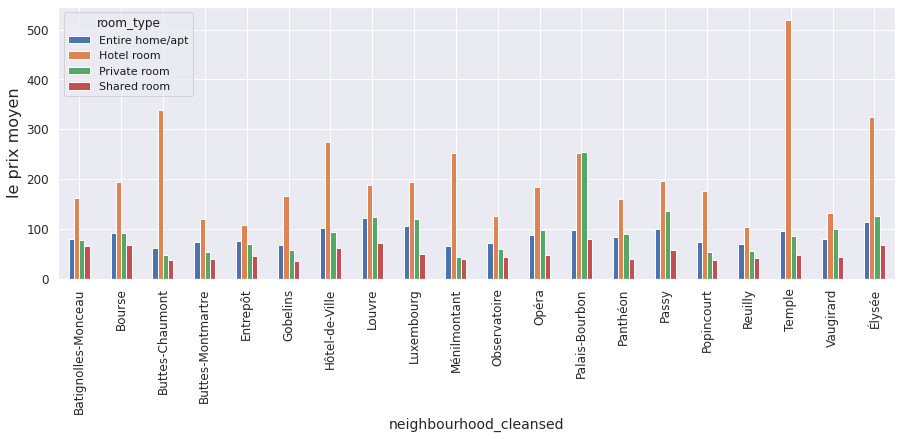

In [ ]:
aux.unstack()['price'].plot.bar(rot=0)
fig.suptitle('le prix moyen d\'une location pour deux personnes par quartier  et par room_type (en 2020)', fontsize=20)
plt.ylabel('le prix moyen', fontsize=16)
plt.xticks(rotation=90)

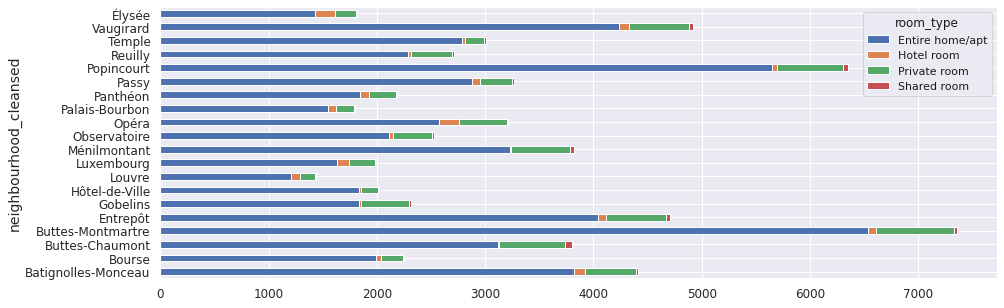

In [ ]:
result = df_listings_clean[['neighbourhood_cleansed','room_type']].pivot_table(index='neighbourhood_cleansed', columns='room_type', aggfunc=len, fill_value=0)
result.plot(kind='barh',stacked=True,legend=True)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


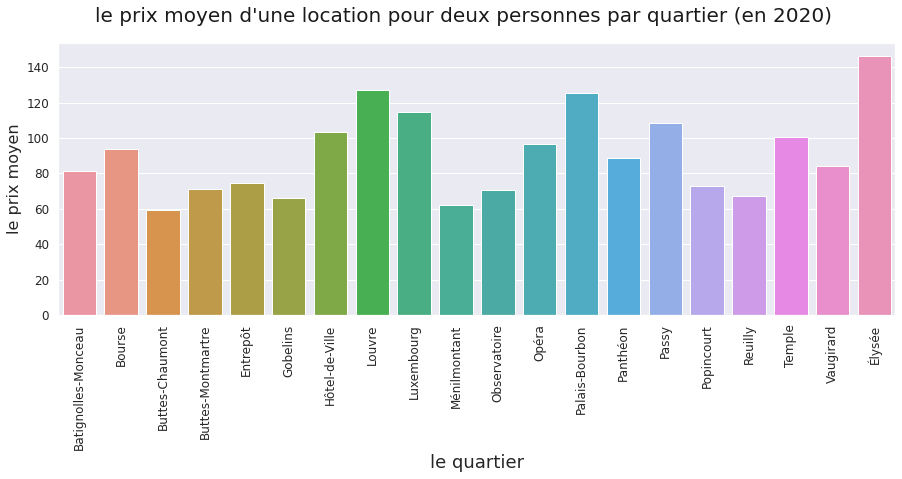

CPU times: user 380 ms, sys: 6 ms, total: 386 ms
Wall time: 386 ms


In [ ]:
%%time
x = [str(i) for i in aux.index]
fig = plt.figure(figsize=(15,5))
g=sns.barplot(x, y=list(aux.price))
fig.suptitle('le prix moyen d\'une location pour deux personnes par quartier (en 2020)', fontsize=20)
plt.xlabel('le quartier', fontsize=18)
plt.ylabel('le prix moyen', fontsize=16)
plt.xticks(rotation=90)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


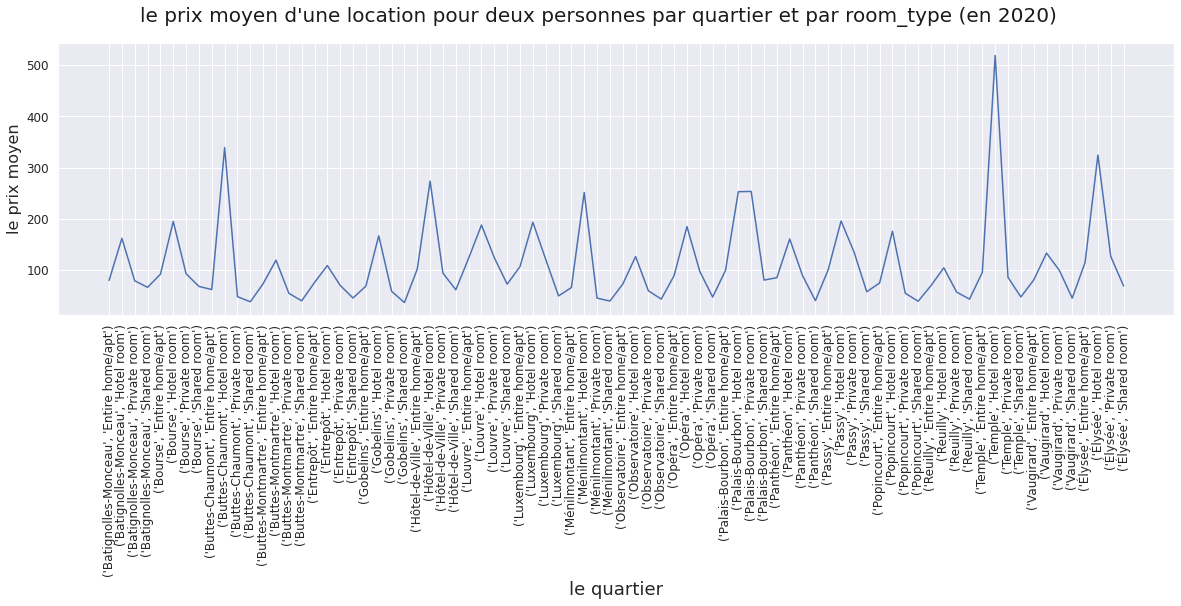

CPU times: user 3.54 s, sys: 627 ms, total: 4.17 s
Wall time: 4.19 s


In [ ]:
%%time
x = [str(i) for i in aux.index]
fig = plt.figure(figsize=(20,5))
g=sns.lineplot(x, y=list(aux.price))
fig.suptitle('le prix moyen d\'une location pour deux personnes par quartier et par room_type (en 2020)', fontsize=20)
plt.xlabel('le quartier', fontsize=18)
plt.ylabel('le prix moyen', fontsize=16)
plt.xticks(rotation=90)
plt.show()

##Calculer les revenus estimés pour chaque listing
Les revenus estimés pour chaque listing seront calculés sur la base du prix d'une nuit et du nombre minimum de nuits à partir de la base de données


In [ ]:
 df_listings_clean['price'].head(5)

0    125.0
1     60.0
2     69.0
3     62.0
4     53.0
Name: price, dtype: float64

In [ ]:
 df_listings_clean['minimum_nights'].head(5)

0     3
1     2
2     5
3     1
4    15
Name: minimum_nights, dtype: int64

In [ ]:
df_listings_clean['revenu'] = df_listings_clean['price'] * df_listings_clean['minimum_nights']
df_listings_clean['revenu'].head(5)

0    375.0
1    120.0
2    345.0
3     62.0
4    795.0
Name: revenu, dtype: float64

In [ ]:
df_listings_clean[['neighbourhood_cleansed','revenu']].groupby(['neighbourhood_cleansed']).mean()

revenu
neighbourhood_cleansed             
Batignolles-Monceau      473.549733
Bourse                   888.942222
Buttes-Chaumont          330.900026
Buttes-Montmartre        566.919848
Entrepôt                 410.576523
Gobelins                 525.680778
Hôtel-de-Ville          1545.826670
Louvre                   885.042420
Luxembourg              1060.662802
Ménilmontant             516.665794
Observatoire             486.244752
Opéra                    460.348178
Palais-Bourbon          1011.906459
Panthéon                 701.520586
Passy                   1250.453990
Popincourt               644.684766
Reuilly                  654.155433
Temple                  1112.437458
Vaugirard                483.368881
Élysée                   916.744365

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


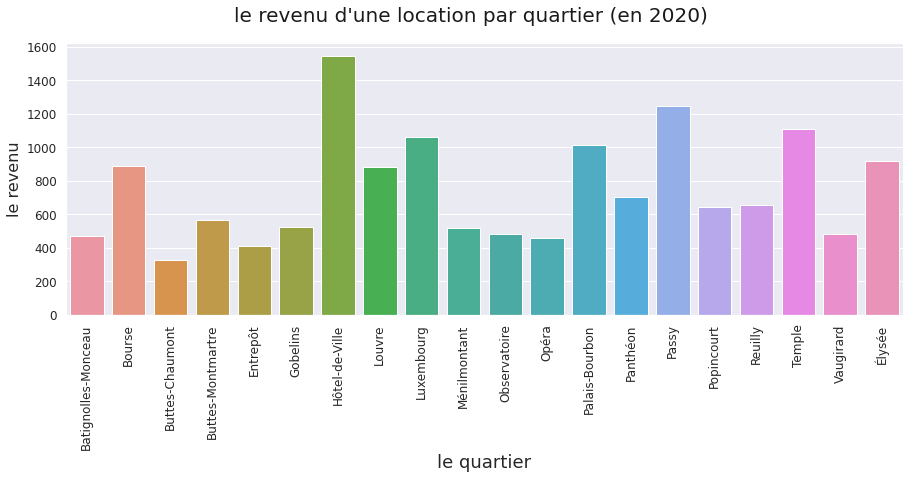

In [ ]:
aux = df_listings_clean[['neighbourhood_cleansed','revenu']].groupby(['neighbourhood_cleansed']).mean()
fig = plt.figure(figsize=(15,5))
g=sns.barplot(aux.index, aux.revenu)
fig.suptitle('le revenu d\'une location par quartier (en 2020)', fontsize=20)
plt.xlabel('le quartier', fontsize=18)
plt.ylabel('le revenu', fontsize=16)
plt.xticks(rotation=90)
plt.show()
del aux

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text major ticklabel objects>)

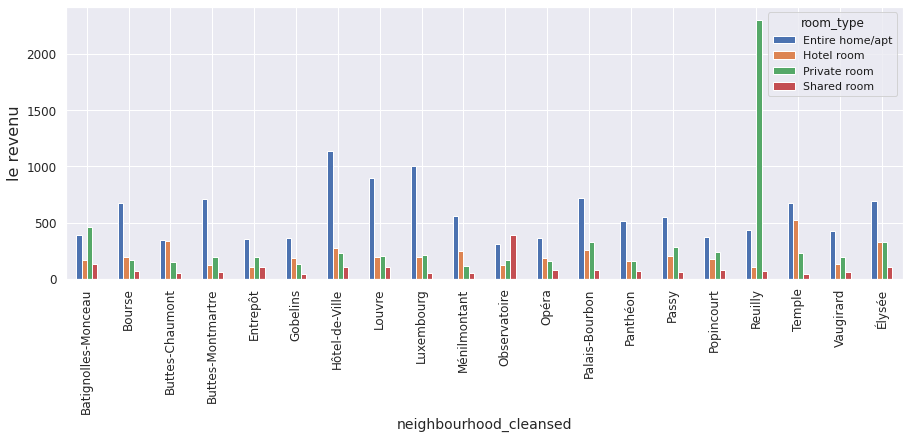

In [ ]:
aux = df_listings_clean[df_listings_clean.accommodates == 2 ].groupby(['neighbourhood_cleansed','room_type']).agg({'revenu': lambda x: x.mean(skipna=False)})
aux.unstack()['revenu'].plot.bar(rot=0)
fig.suptitle('le revenu d\'une location par quartier et par room_type (en 2020) (en 2020)', fontsize=20)
plt.ylabel('le revenu', fontsize=16)
plt.xticks(rotation=90)

In [ ]:
import folium
my_map = folium.Map(location=[48.838151, 2.583275], zoom_start=10)
display(my_map)

In [ ]:
my_map = folium.Map(location=[48.838151, 2.583275], zoom_start=10)
locations = df_listings_clean.loc[df_listings_clean.neighbourhood_cleansed =="Hôtel-de-Ville",['latitude', 'longitude']]
locationlist = locations.values.tolist()
for point in range(0, len(locationlist)):
    folium.Marker(locationlist[point], popup=df_listings_clean['name'][point]).add_to(my_map)
my_map.save( 'quartier_avec_le_plus_cher_revenu_map.html')

In [ ]:
display(my_map)

- Cette fois-ci en se basant sur la colonne prix au lieu de revenu
je récupère les 100 listings les plus chers 

In [ ]:
my_map = folium.Map(location=[48.838151, 2.583275], zoom_start=10)
locations = df_listings_clean.sort_values(by=['price'], ascending=False).loc[:,['latitude', 'longitude']][:100]
locationlist = locations.values.tolist()
for point in range(0, len(locationlist)):
    folium.Marker(locationlist[point], popup=df_listings_clean['neighbourhood_cleansed'][point]).add_to(my_map)
my_map.save( 'highest_100_price_map.html')

In [ ]:
display(my_map)

## Type de bien a acherter

In [ ]:
df_listings_clean.price.max()

11600.0

In [ ]:
df_listings_clean.property_type

0                      Entire loft
1                 Entire apartment
2                 Entire apartment
3                 Entire apartment
4                 Entire apartment
                   ...            
65912                Room in hotel
65913             Entire apartment
65914             Entire apartment
65915    Private room in apartment
65916             Entire apartment
Name: property_type, Length: 65917, dtype: category
Categories (67, object): ['Barn', 'Boat', 'Camper/RV', 'Campsite', ...,
                          'Shared room in tiny house', 'Shared room in townhouse', 'Tiny house', 'Treehouse']

In [ ]:
listing_type = df_listings_clean.sort_values(by=['price'], ascending=False).loc[:,['room_type', 'property_type']][:1000]
listing_type

room_type     property_type
65030  Entire home/apt  Entire apartment
56167  Entire home/apt  Entire apartment
55455  Entire home/apt  Entire apartment
44253  Entire home/apt  Entire apartment
36889  Entire home/apt  Entire apartment
...                ...               ...
40869  Entire home/apt  Entire apartment
25300  Entire home/apt       Entire loft
29191  Entire home/apt  Entire apartment
22372  Entire home/apt  Entire apartment
28617  Entire home/apt  Entire apartment

[1000 rows x 2 columns]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


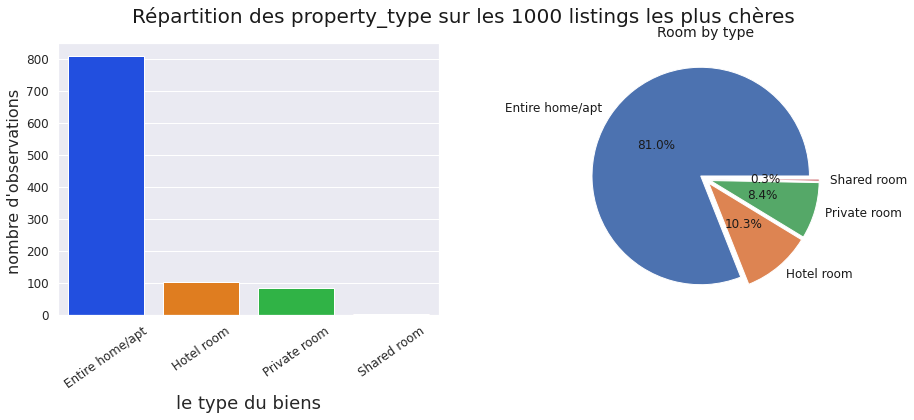

In [ ]:
aux = listing_type.room_type.value_counts()
x = [str(i) for i in aux.index]
fig = plt.figure(figsize=(15,5))
plt.subplot(1,2,1);
g=sns.barplot(x, y=list(aux), palette="bright")
fig.suptitle('Répartition des property_type sur les 1000 listings les plus chères', fontsize=20)
plt.xlabel('le type du biens', fontsize=18)
plt.ylabel('nombre d\'observations ', fontsize=16)
plt.xticks(rotation=35)
plt.subplot(1,2,2);
plt.pie(x=list(aux), autopct="%.1f%%", explode=[0.05]*4, labels=x, pctdistance=0.5)
plt.title("Room by type", fontsize=14);
del aux
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


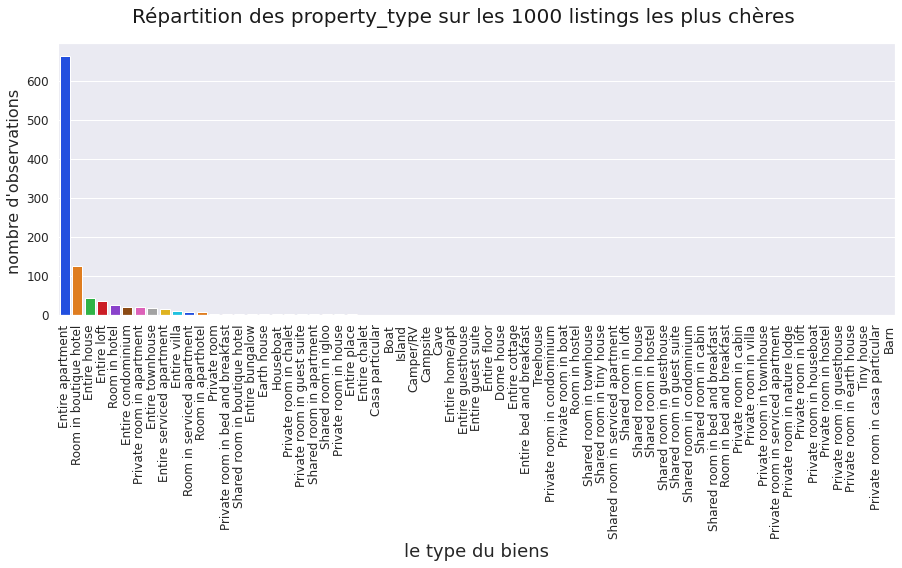

In [ ]:
aux = listing_type.property_type.value_counts()
x = [str(i) for i in aux.index]
fig = plt.figure(figsize=(15,5))
g=sns.barplot(x, y=list(aux), palette="bright")
fig.suptitle('Répartition des property_type sur les 1000 listings les plus chères', fontsize=20)
plt.xlabel('le type du biens', fontsize=18)
plt.ylabel('nombre d\'observations ', fontsize=16)
plt.xticks(rotation=90)
del aux
plt.show()

# **Sauvegarder les données sans les nouvelles computed columns**

In [ ]:
df_listings_clean.head()

In [ ]:
categorical_var

['host_is_superhost',
 'host_has_profile_pic',
 'host_identity_verified',
 'neighbourhood_cleansed',
 'property_type',
 'room_type',
 'bathrooms_text',
 'has_availability',
 'instant_bookable']

In [ ]:
category_one_hot_encoding = pd.get_dummies(df_listings_clean[categorical_var])
category_one_hot_encoding
df_listings_without_new_cols = pd.concat([df_listings_clean, category_one_hot_encoding],
                            axis='columns').drop(categorical_var,
                                                 axis='columns')
# Saving the preprocessed data
df_listings_without_new_cols.to_csv('/content/drive/MyDrive/ML-PROJECT/df_listings_clean_encoded_no_fe.csv')

In [ ]:
# Saving the preprocessed data
df_listings_clean.to_csv('/content/drive/MyDrive/ML-PROJECT/df_listings_clean_not_encoded_no_fe.csv')

#Fusionner le dataset initial **`df_listings_clean`** avec le dataset **`merged_df`** des colonnes amenities, host_verification et description

In [ ]:
print("merged_df dataframe shape: ", merged_df.shape)
print("df_listings_clean dataframe shape: ", df_listings_clean.shape)

merged_df dataframe shape:  (65917, 2569)
df_listings_clean dataframe shape:  (65917, 48)


In [ ]:
df_listings_clean.shape

(65917, 48)

In [ ]:
df_listings_without_new_cols.shape

(65917, 171)

In [ ]:
merged_df_listings_clean = pd.concat([df_listings_clean, merged_df], axis='columns')
merged_df_listings_clean.shape

(65917, 2617)

In [ ]:
import gc
gc.collect()

191276

In [ ]:
merged_df_listings_clean.columns[:52]

Index(['listing_id', 'name', 'description', 'host_is_superhost',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood_cleansed', 'latitude', 'longitude', 'property_type',
       'room_type', 'accommodates', 'bathrooms_text', 'bedrooms', 'beds',
       'amenities', 'price', 'minimum_nights', 'maximum_nights',
       'has_availability', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'number_of_reviews',
       'number_of_reviews_ltm', 'number_of_reviews_l30d', 'last_review',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'instant_bookable',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_room

In [ ]:
(merged_df_listings_clean.calculated_host_listings_count.values == merged_df_listings_clean.calculated_host_listings_count_shared_rooms.values).all()

False

In [ ]:
col_to_delete=["name", "description","host_listings_count", "host_verifications", "amenities", 
               "last_review", "amenities_count", "revenu"]
for col in col_to_delete:
    merged_df_listings_clean.drop(col, axis=1, inplace=True)

In [ ]:
merged_df_listings_clean.columns[:40]

Index(['listing_id', 'host_is_superhost', 'host_total_listings_count',
       'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood_cleansed', 'latitude', 'longitude', 'property_type',
       'room_type', 'accommodates', 'bathrooms_text', 'bedrooms', 'beds',
       'price', 'minimum_nights', 'maximum_nights', 'has_availability',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'number_of_reviews', 'number_of_reviews_ltm',
       'number_of_reviews_l30d', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'instant_bookable',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'reviews_per_month',
       'host_local', 'host_expe

In [ ]:
merged_df_listings_clean.loc[:,["calculated_host_listings_count_private_rooms","reviews_per_month"]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65917 entries, 0 to 65916
Data columns (total 2 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   calculated_host_listings_count_private_rooms  65917 non-null  int64  
 1   reviews_per_month                             65917 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 1.0 MB


In [ ]:
merged_df_listings_clean.host_identity_verified.value_counts()

t    50583
f    15334
Name: host_identity_verified, dtype: int64

In [ ]:
listings_initial_cols_values = list(merged_df_listings_clean.columns[:40])
merged_df_listings_clean.loc[:,listings_initial_cols_values].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65917 entries, 0 to 65916
Data columns (total 41 columns):
 #   Column                                        Non-Null Count  Dtype   
---  ------                                        --------------  -----   
 0   listing_id                                    65917 non-null  int64   
 1   host_is_superhost                             65917 non-null  object  
 2   host_total_listings_count                     65917 non-null  float64 
 3   host_has_profile_pic                          65917 non-null  object  
 4   host_identity_verified                        65917 non-null  object  
 5   neighbourhood_cleansed                        65917 non-null  category
 6   latitude                                      65917 non-null  float64 
 7   longitude                                     65917 non-null  float64 
 8   property_type                                 65917 non-null  category
 9   room_type                                     6591

In [ ]:
# Saving the preprocessed data  df_listings_clean_not_encoded_no_fe
merged_df_listings_clean.to_csv('/content/drive/MyDrive/ML-PROJECT/df_listings_clean_not_encoded_with_fe.csv')


#One-hot encode the categorical variables

In [ ]:
categorical_var

['host_is_superhost',
 'host_has_profile_pic',
 'host_identity_verified',
 'neighbourhood_cleansed',
 'property_type',
 'room_type',
 'bathrooms_text',
 'has_availability',
 'instant_bookable']

In [ ]:
category_one_hot_encoding = pd.get_dummies(merged_df_listings_clean[categorical_var])
category_one_hot_encoding

host_is_superhost_f  host_is_superhost_t  host_has_profile_pic_f  \
0                        1                    0                       0   
1                        1                    0                       0   
2                        1                    0                       0   
3                        1                    0                       0   
4                        0                    1                       0   
...                    ...                  ...                     ...   
65912                    1                    0                       0   
65913                    1                    0                       0   
65914                    1                    0                       0   
65915                    1                    0                       0   
65916                    1                    0                       0   

       host_has_profile_pic_t  host_identity_verified_f  \
0                           1                         0   
1                           1                         1   
2                           1                         0   
3                           1                         0   
4                           1                         0   
...                       ...                       ...   
65912                       1                         0   
65913                       1                         0   
65914                       1                         0   
65915                       1                         0   
65916                       1                         0   

       host_identity_verified_t  neighbourhood_cleansed_Batignolles-Monceau  \
0                             1                                           0   
1                             0                                           0   
2                             1                                           0   
3                             1                                           0   
4                             1                                           0   
...                         ...                                         ...   
65912                         1                                           0   
65913                         1                                           0   
65914                         1                                           0   
65915                         1                                           0   
65916                         1                                           0   

       neighbourhood_cleansed_Bourse  neighbourhood_cleansed_Buttes-Chaumont  \
0                                  0                                       0   
1                                  0                                       0   
2                                  0                                       0   
3                                  0                                       0   
4                                  0                                       0   
...                              ...                                     ...   
65912                              0                                       0   
65913                              0                                       0   
65914                              0                                       0   
65915                              0                                       1   
65916                              0                                       1   

       neighbourhood_cleansed_Buttes-Montmartre  \
0                                             0   
1                                             0   
2                                             0   
3                                             0   
4                                             0   
...                                         ...   
65912                                         0   
65913                                         0   
65914                       

In [ ]:
category_one_hot_encoding.shape

(65917, 132)

In [ ]:
merged_df_listings_clean.shape

(65917, 2607)

In [ ]:
merged_df_listings_clean.review_scores_location

0        10.0
1        10.0
2        10.0
3        10.0
4        10.0
         ... 
65912    10.0
65913    10.0
65914    10.0
65915    10.0
65916    10.0
Name: review_scores_location, Length: 65917, dtype: float64

- Fusionner ces deux dataframe et supprimer les variables catégorielles par ce quelles vont etre remplacées par leurs dummies



In [ ]:
df_listings_onehot_encoded = pd.concat([merged_df_listings_clean, category_one_hot_encoding],
                            axis='columns').drop(categorical_var,
                                                 axis='columns')
df_listings_onehot_encoded.shape

(65917, 2730)

In [ ]:
df_listings_onehot_encoded.columns

Index(['listing_id', 'host_total_listings_count', 'latitude', 'longitude',
       'accommodates', 'bedrooms', 'beds', 'price', 'minimum_nights',
       'maximum_nights',
       ...
       'bathrooms_text_7 shared baths', 'bathrooms_text_7.5 baths',
       'bathrooms_text_8 baths', 'bathrooms_text_Half-bath',
       'bathrooms_text_Private half-bath', 'bathrooms_text_Shared half-bath',
       'has_availability_f', 'has_availability_t', 'instant_bookable_f',
       'instant_bookable_t'],
      dtype='object', length=2730)

In [ ]:
# Saving the preprocessed data
df_listings_onehot_encoded.to_csv('/content/drive/MyDrive/ML-PROJECT/df_listings_clean_encoded_with_fe.csv')

#Nettoyage du dataset Calendar
---



In [ ]:
%%time
# Load calendar dataset which contain information about the reservations of these properties over the coming year
df_calendar = pd.read_csv("http://data.insideairbnb.com/france/ile-de-france/paris/2020-12-14/data/calendar.csv.gz")

CPU times: user 16.8 s, sys: 3.17 s, total: 20 s
Wall time: 26 s


In [ ]:
df_calendar[df_calendar.listing_id == 12268]

listing_id        date available   price adjusted_price  \
16789       12268  2020-12-27         f  $60.00         $60.00   
16790       12268  2020-12-28         f  $60.00         $60.00   
16791       12268  2020-12-29         f  $60.00         $60.00   
16792       12268  2020-12-30         f  $60.00         $60.00   
16793       12268  2020-12-31         f  $60.00         $60.00   
...           ...         ...       ...     ...            ...   
17394       12268  2021-12-22         f  $60.00         $60.00   
17395       12268  2021-12-23         f  $60.00         $60.00   
17396       12268  2021-12-24         f  $60.00         $60.00   
17397       12268  2021-12-25         f  $60.00         $60.00   
17398       12268  2021-12-26         f  $60.00         $60.00   

       minimum_nights  maximum_nights  
16789             6.0            40.0  
16790             6.0            40.0  
16791             6.0            40.0  
16792             6.0            40.0  
16793             6.0            40.0  
...               ...             ...  
17394             6.0            40.0  
17395             6.0            40.0  
17396             6.0            40.0  
17397             6.0            40.0  
17398             6.0            40.0  

[365 rows x 7 columns]

In [ ]:
df_calendar.head()

listing_id        date available    price adjusted_price  minimum_nights  \
0       31893  2020-12-17         f   $85.00         $85.00             6.0   
1        2577  2020-12-16         t  $125.00        $125.00             3.0   
2        2577  2020-12-17         t  $125.00        $125.00             3.0   
3        2577  2020-12-18         t  $125.00        $125.00             3.0   
4        2577  2020-12-19         t  $125.00        $125.00             3.0   

   maximum_nights  
0            15.0  
1          1125.0  
2          1125.0  
3          1125.0  
4          1125.0

In [ ]:
df_calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24063315 entries, 0 to 24063314
Data columns (total 7 columns):
 #   Column          Dtype  
---  ------          -----  
 0   listing_id      int64  
 1   date            object 
 2   available       object 
 3   price           object 
 4   adjusted_price  object 
 5   minimum_nights  float64
 6   maximum_nights  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 1.3+ GB


In [ ]:
miss_calendar = df_calendar.isnull().sum() / len(df_calendar)
miss_calendar[miss_calendar > 0]

price             0.000165
adjusted_price    0.000165
minimum_nights    0.000360
maximum_nights    0.000360
dtype: float64

In [ ]:
df_calendar.available.value_counts()

f    17086872
t     6976443
Name: available, dtype: int64

- La colonne **prix** et **prix_ajusté**, qui sont le prix de l'annonce, contient le signe du dollar ($). Nous ne pouvons toujours pas l'utiliser pour l'analyse car il ne s'agit pas d'une valeur numérique, nous retirons donc le symbole du dollar et convertissons les valeurs en valeurs numériques :

In [ ]:
%%time
df_calendar['price'] = df_calendar['price'].str.replace("[$, ]", "").astype("float")
df_calendar['adjusted_price'] = df_calendar['adjusted_price'].str.replace("[$, ]", "").astype("float")

CPU times: user 47.4 s, sys: 3.18 s, total: 50.6 s
Wall time: 51.3 s


Convert the date column to datetime and extract year and month from it and sort the dataset by date:

In [ ]:
%%time
df_calendar['date'] =  pd.to_datetime(df_calendar['date'], format='%Y-%m-%d')
df_calendar['year'] = df_calendar['date'].dt.year
df_calendar['month'] = df_calendar['date'].dt.month
df_calendar = df_calendar.sort_values('date', ascending=True)

In [ ]:
print("the collected data was between %s and %s"%(df_calendar.date.iloc[0],df_calendar.date.iloc[-1]))

- Vérification si le nombre d'identifiants uniques est le même dans listings.csv et calendar.csv, ce qui n'est pas le cas puisque listings.csv contient 65917 identifiants uniques et calendar.csv contient 65905 identifiants

In [ ]:
len(df_listings_clean.listing_id.value_counts())

In [ ]:
len(df_calendar.listing_id.value_counts())

In [ ]:
check = df_calendar.iloc[:,[0,3]]
check

- Calcul du prix moyen des réservation d'un meme listing 

In [ ]:
  check.groupby(['listing_id']).agg({'price': lambda x: x.mean(skipna=False)})

In [ ]:
df_listings_clean.loc[:,['listing_id', 'price']]

- Récupération des réservation de 2020

In [ ]:
df_2020 = df_calendar[df_calendar.year == 2020]
df_2020.month.value_counts()

In [ ]:
df_listings_clean[df_listings_clean.listing_id == 25976938][['price', 'minimum_nights', 'maximum_nights']]

Toute les réservations en 2020 pour le listing avec l'id 25976938

In [ ]:
df_2020[df_2020.listing_id == 25976938][['price', 'minimum_nights', 'maximum_nights','year']]

In [ ]:
df_2020[df_2020.listing_id == 25976938].iloc[0].price == df_listings_clean[df_listings_clean.listing_id == 25976938].price

- Comparaison des prix mentionné sur les réservations effectuées en 2020 dans le fichier calendar.csv avec les prix indiqués dans le fichier listing.csv.

In [ ]:
for id in df_listings_clean.listing_id:
  for id2 in df_2020.listing_id:
    if id == id2:
    #  print("df_calendar en 2020 :",df_2020[df_2020.listing_id == id].iloc[0].price )
    #  print("df_listings_cleaned :", df_listings_clean[df_listings_clean.listing_id == id2].iloc[0].price)


      if df_2020[df_2020.listing_id == id].iloc[0].price == df_listings_clean[df_listings_clean.listing_id == id2].iloc[0].price:
        print("Yes, equal price for the sale listings ID! !")
      else:
        print("listing_id",id,"==","calendar_id", id2)
        print("Price in df_calendar en 2020 :",df_2020[df_2020.listing_id == id].iloc[0].price )
        print("Price in df_listings_cleaned :", df_listings_clean[df_listings_clean.listing_id == id2].iloc[0].price)
        print("Not equal price for the sale listings ID!")

# (df_listings_clean[df_listings_clean.listing_id == id].minimum_nights == df_2020[df_2020.listing_id == id].minimum_nights) and
#       (df_listings_clean[df_listings_clean.listing_id == id].maximum_nights == df_2020[df_2020.listing_id == id].maximum_nights)):
      

#Merging the calendar and listings datasets

---



In [ ]:
# %%time
# df_bookings = pd.merge(df_calendar, df_listings, on='listing_id')
# df_bookings.head()

In [ ]:
df_listings.loc[df_listings.listing_id ==2577,'price']

In [ ]:
df_calendar.groupby(['listing_id']).size()

# Visualisations

---



In [ ]:
%%time
aux = df_calendar.groupby(['year', 'month']).size()
x = [str(i[0])+"-"+str(i[1]) for i in aux.index]
fig = plt.figure(figsize=(15,5))
g=sns.barplot(x, y=aux)
fig.suptitle('Répartition des réservation sur les mois de l\'année', fontsize=20)
plt.xlabel('le mois et l\'année', fontsize=18)
plt.ylabel('nombre de réservations', fontsize=16)
plt.xticks(rotation=45)
plt.show()

In [ ]:
# x=df_calendar.groupby(['listing_id']).agg('count')
# result = df_calendar[['listing_id','available']].pivot_table(index='listing_id', columns='available', aggfunc=len, fill_value=0)
# ## plot it
# fig = plt.figure(figsize=(15,5))
# ax1 = fig.add_subplot(121)
# ax2 = fig.add_subplot(122)
# result.plot(kind='barh',stacked=True,legend=True,ax=ax1)
# ax1.yaxis.grid(True)
# ax1.set_xlabel('Number of Entries')

# x[['available']].plot(kind='barh',stacked=False,legend=False,ax=ax2)
# ax2.yaxis.grid(True)
# ax2.set_xlabel('Number of Entries')
# ax2.set_ylabel('available')

# #df['education'].value_counts().plot(kind='barh')
# plt.show()


In [ ]:
df_listings.price.value_counts()

In [ ]:
_, bins = np.histogram(np.log10(df_listings.price + 1), bins='auto')
plt.hist(df_listings.price, bins=10**bins);
plt.gca().set_xscale("log")

In [ ]:
g = sns.countplot(x='neighbourhood_cleansed', data=df_listlistings_sampleings_clean);
g.set_xticklabels(g.get_xticklabels(), rotation=90);

In [ ]:
data = df_listings.groupby(['room_type']).size()
data

In [ ]:
plt.figure(figsize=(14,4))
plt.subplot(1,2,1);
g = sns.countplot(x='room_type', data=listings_sample);
g.set_xticklabels(g.get_xticklabels(), rotation=45);
plt.subplot(1,2,2);
data = df_listings.groupby(['room_type']).size()
labels = data.keys()
plt.pie(x=data, autopct="%.1f%%", explode=[0.05]*4, labels=labels, pctdistance=0.5)
plt.title("Room by type", fontsize=14);
del data

In [ ]:
df_listings.head()

In [ ]:
df_calendar.head()